<div align="center">

# Investigating Image Authenticity Using ResNet and Vision Transformer (ViT) Models

</div>


###  Preprocessing and Augmentation

We applied a series of filters to enhance distinguishing features in the images:

- **Low-pass (Gaussian blur)** to smooth out noise,
- **Medium-pass** to balance detail and smoothness,
- **High-pass & High-boost** to emphasize edges and fine textures,
- **Homomorphic filtering** to correct lighting inconsistencies,
- **Sobel filter** to extract edge features.

Each image was resized to 256×256 pixels and saved with multiple filtered versions. We also used **Albumentations** for data augmentation (flip, rotate, blur, brightness/contrast, distortion) to improve model robustness.




In [ ]:
import os
import cv2
import numpy as np
from scipy.fftpack import fft2, ifft2
from skimage.exposure import rescale_intensity
import albumentations as A
from tqdm import tqdm

# Define Paths
INPUT_DIR = "/Users/amritaajaysagar/Downloads/archive"  # Change this if needed "/Users/amritaajaysagar/Downloads/archive"
OUTPUT_DIR = "/Users/amritaajaysagar/Downloads/archive_preprocessed"

# Folder Structure (Train/Test -> FAKE/REAL)
DATASETS = ["train", "test"]
CATEGORIES = ["FAKE", "REAL"]

# Ensure output directories exist
for dataset in DATASETS:
    for category in CATEGORIES:
        os.makedirs(os.path.join(OUTPUT_DIR, dataset, category), exist_ok=True)

# Preprocessing Functions
def apply_low_pass_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_medium_pass_filter(image):
    low_pass = apply_low_pass_filter(image)
    return cv2.addWeighted(image, 1.5, low_pass, -0.5, 0)

def apply_high_pass_filter(image):
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    return cv2.filter2D(image, -1, kernel)

def apply_high_boost_filter(image, alpha=1.5):
    low_pass = apply_low_pass_filter(image)
    return cv2.addWeighted(image, alpha, low_pass, -1 * (alpha - 1), 0)

def apply_homomorphic_filter(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_log = np.log1p(np.array(image, dtype="float"))
    fft = fft2(image_log)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols), np.float32)
    mask[crow - 30:crow + 30, ccol - 30:ccol + 30] = 0  # Low-pass suppression

    fft_shift = fft * mask
    filtered_image = np.abs(ifft2(fft_shift))
    return rescale_intensity(filtered_image, out_range=(0, 255)).astype("uint8")

def apply_sobel_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel = cv2.magnitude(sobelx, sobely)
    return cv2.cvtColor(np.uint8(sobel), cv2.COLOR_GRAY2BGR)



# Data Augmentation Pipeline (Albumentations)
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GridDistortion(p=0.2),
    A.ElasticTransform(p=0.2)
])

# Process Images
for dataset in DATASETS:
    for category in CATEGORIES:
        input_path = os.path.join(INPUT_DIR, dataset, category)
        output_path = os.path.join(OUTPUT_DIR, dataset, category)

        for img_name in tqdm(os.listdir(input_path), desc=f"Processing {dataset}/{category}"):
            img_path = os.path.join(input_path, img_name)
            image = cv2.imread(img_path)

            if image is None:
                continue

            # Resize for consistency
            image = cv2.resize(image, (256, 256))

            # Apply preprocessing filters
            low_pass = apply_low_pass_filter(image)
            medium_pass = apply_medium_pass_filter(image)
            high_pass = apply_high_pass_filter(image)
            high_boost = apply_high_boost_filter(image)
            homomorphic = apply_homomorphic_filter(image)
            sobel = apply_sobel_filter(image)
            #eroded = apply_image_erosion(image)
            #dilated = apply_image_dilation(image)

            # Save Preprocessed Images
            cv2.imwrite(os.path.join(output_path, f"lowpass_{img_name}"), low_pass)
            cv2.imwrite(os.path.join(output_path, f"mediumpass_{img_name}"), medium_pass)
            cv2.imwrite(os.path.join(output_path, f"highpass_{img_name}"), high_pass)
            cv2.imwrite(os.path.join(output_path, f"highboost_{img_name}"), high_boost)
            cv2.imwrite(os.path.join(output_path, f"homomorphic_{img_name}"), homomorphic)
            cv2.imwrite(os.path.join(output_path, f"sobel_{img_name}"), sobel)


            # Data Augmentation (Save multiple variants)
            for i in range(3):
                augmented = augmentations(image=image)["image"]
                cv2.imwrite(os.path.join(output_path, f"aug_{i}_{img_name}"), augmented)

print(" Preprocessing and Augmentation Complete. Processed images saved in:", OUTPUT_DIR)


/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Processing test/REAL: 100%|██████████| 10000/10000 [01:00<00:00, 165.64it/s]

 Preprocessing and Augmentation Complete. Processed images saved in: /Users/amritaajaysagar/Downloads/archive_preprocessed


###  Subset Creation

To enable faster local experimentation, we created smaller, stratified subsets of the CIFAKE dataset for training and testing:

- **Training Subset**: 10000 real + 10000 fake images  
- **Testing Subset**: 1000 real + 1000 fake images

The images were randomly shuffled and selected to maintain balance across both classes. Separate folders were created to store the subset data, preserving the original directory structure (REAL and FAKE).


In [ ]:
# create a subset of the data
import os
import random
import shutil
# create a stratified sample of 20000 images
# 10000 real and 10000 fake images
real_images = os.listdir('/Users/amritaajaysagar/Downloads/archive_preprocessed/train/REAL')
fake_images = os.listdir('/Users/amritaajaysagar/Downloads/archive_preprocessed/train/FAKE')
# shuffle the images
random.shuffle(real_images)
random.shuffle(fake_images)
# create a subset
subset = 10000
real_subset = real_images[:subset]
fake_subset = fake_images[:subset]
# create a new directory
os.makedirs('/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/REAL', exist_ok=True)
os.makedirs('/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE', exist_ok=True)
# copy the images
for img in real_subset:
    shutil.copyfile(f'/Users/amritaajaysagar/Downloads/archive_preprocessed/train/REAL/{img}', f'/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/REAL/{img}')
for img in fake_subset:
    shutil.copyfile(f'/Users/amritaajaysagar/Downloads/archive_preprocessed/train/FAKE/{img}', f'/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/{img}')
print('Subset created successfully.')

Subset created successfully.


In [ ]:
# create a subset for test data
# create a stratified sample of 2000 images
# 1000 real and 1000 fake images
real_images = os.listdir('/Users/amritaajaysagar/Downloads/archive/test/REAL')
fake_images = os.listdir('/Users/amritaajaysagar/Downloads/archive/test/FAKE')
# shuffle the images
random.shuffle(real_images)
random.shuffle(fake_images)
# create a subset
subset = 1000
real_subset = real_images[:subset]
fake_subset = fake_images[:subset]
# create a new directory
os.makedirs('/Users/amritaajaysagar/Downloads/archive/test_subset/REAL', exist_ok=True)
os.makedirs('/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE', exist_ok=True)
# copy the images
for img in real_subset:
    shutil.copyfile(f'/Users/amritaajaysagar/Downloads/archive/test/REAL/{img}', f'/Users/amritaajaysagar/Downloads/archive/test_subset/REAL/{img}')
for img in fake_subset:
    shutil.copyfile(f'/Users/amritaajaysagar/Downloads/archive/test/FAKE/{img}', f'/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE/{img}')
print('Subset created successfully.')


Subset created successfully.


### Model Training – ResNet-50

We trained a ResNet-50 model for binary classification (REAL vs FAKE images) using the preprocessed and augmented subsets:

- **Architecture**: Pretrained ResNet-50 with a modified final layer for 2 output classes.
- **Input**: 256×256 normalized grayscale images.
- **Loss Function**: CrossEntropyLoss.
- **Optimizer**: AdamW with a learning rate of 1e-4.
- **Batch Size**: 16 (tuned for GPU efficiency).
- **Epochs**: 5 (for quick experimentation).
- **Training Optimization**:
  - Mixed Precision Training (via `autocast` and `GradScaler`) for faster computation and lower memory usage.
  - `torch.backends.cudnn` settings used to speed up training when input size is fixed.

We used stratified subsets (10,000 real and 10,000 fake for training) and evaluated performance using accuracy per epoch.


In [ ]:
import os
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enable faster GPU processing
torch.backends.cudnn.benchmark = True  # Enable faster training if input size is fixed
torch.backends.cudnn.deterministic = False  # Allow optimizations

# Define Paths
DATA_DIR = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_DATA_DIR = "/Users/amritaajaysagar/Downloads/archive/test_subset"

BATCH_SIZE = 16  # Reduced for better GPU performance
NUM_WORKERS = 8  # Increase workers to speed up data loading
IMAGE_SIZE = (256, 256)
NUM_CLASSES = 2  # FAKE and REAL
EPOCHS = 5  # Keep minimal to test speed
LEARNING_RATE = 1e-4

# Define Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Single-channel grayscale normalization
])

# Load Datasets
train_dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DATA_DIR, transform=transform)

# Create DataLoaders (Optimized)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

# Load ResNet-50 (Faster than ResNet-101)
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Modify Final Layer for Binary Classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)

# Use Mixed Precision Training
scaler = GradScaler()

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Training Function (With Mixed Precision)
def train_model(model, train_loader, criterion, optimizer, epochs=EPOCHS):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            with autocast():  # Mixed Precision Training
                outputs = model(images)
                loss = criterion(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()  # Scale gradients to prevent underflow
            scaler.step(optimizer)
            scaler.update()

            # Track Loss and Accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

    print("Training Complete!")

# Train the Model (With Optimizations)
train_model(model, train_loader, criterion, optimizer, epochs=EPOCHS)


In [ ]:
#this model here is not used anyhwere this was trained on a different dataset , just  here for reference
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths (New Structure)
DATA_DIR = "data_preprocessed"
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 2  # FAKE and REAL
EPOCHS = 10
LEARNING_RATE = 0.0001

# Define Transforms (Data Augmentation)
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset (Using Ai_Images as FAKE and Camera_Images as REAL)
dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)

# Split Dataset into Train and Test (80% Train, 20% Test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Load Pretrained ResNet101 Model
model = models.resnet101(pretrained=True)

# Modify the Final Layer for Binary Classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# Move Model to Device
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    best_accuracy = 0.0
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track Loss and Accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

        # Save Best Model
        if epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            torch.save(model.state_dict(), "best_resnet101_model.pth")

    print(" Training Complete! Best Accuracy:", best_accuracy)

# Model Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f" Model Accuracy on Test Set: {accuracy:.2f}%")
    return accuracy

# Train and Evaluate Model
train_model(model, train_loader, criterion, optimizer, epochs=EPOCHS)
evaluate_model(model, test_loader)

# Save Final Model
MODEL_PATH = "resnet101_fake_vs_real.pth"
torch.save(model.state_dict(), MODEL_PATH)
print(f" Model saved at {MODEL_PATH}")



Epoch 1/10: 100%|██████████| 250/250 [20:40<00:00,  4.96s/it]


Epoch 1: Loss = 0.2927, Accuracy = 86.80%


Epoch 2/10: 100%|██████████| 250/250 [20:04<00:00,  4.82s/it]


Epoch 2: Loss = 0.1708, Accuracy = 93.35%


Epoch 3/10: 100%|██████████| 250/250 [20:54<00:00,  5.02s/it]


Epoch 3: Loss = 0.1472, Accuracy = 94.03%


Epoch 4/10: 100%|██████████| 250/250 [21:14<00:00,  5.10s/it]


Epoch 4: Loss = 0.1032, Accuracy = 96.11%


Epoch 5/10: 100%|██████████| 250/250 [19:34<00:00,  4.70s/it]


Epoch 5: Loss = 0.1138, Accuracy = 95.53%


Epoch 6/10: 100%|██████████| 250/250 [19:07<00:00,  4.59s/it]


Epoch 6: Loss = 0.0643, Accuracy = 97.44%


Epoch 7/10: 100%|██████████| 250/250 [19:32<00:00,  4.69s/it]


Epoch 7: Loss = 0.0980, Accuracy = 96.79%


Epoch 8/10: 100%|██████████| 250/250 [19:04<00:00,  4.58s/it]


Epoch 8: Loss = 0.1022, Accuracy = 96.16%


Epoch 9/10: 100%|██████████| 250/250 [20:36<00:00,  4.95s/it]


Epoch 9: Loss = 0.0832, Accuracy = 97.01%


Epoch 10/10: 100%|██████████| 250/250 [19:38<00:00,  4.71s/it]


Epoch 10: Loss = 0.1096, Accuracy = 96.21%
 Training Complete! Best Accuracy: 97.44104365278474


Evaluating Model: 100%|██████████| 63/63 [03:02<00:00,  2.90s/it]


 Model Accuracy on Test Set: 96.79%
 Model saved at resnet101_fake_vs_real.pth


In [ ]:
# use the saved model to classify an image continuation from previous
import cv2
import torch
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image

# Load the Model
model = models.resnet101(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("resnet101_fake_vs_real.pth"))
model.eval()

#use the model to classify an image
def classify_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)  # Convert NumPy array to PIL image
    img_tensor = transform(img_pil).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)

    _, predicted = torch.max(outputs, 1)
    return "REAL" if predicted.item() == 0 else  "FAKE"

# Example Usage
image_path = '/Users/amritaajaysagar/Downloads/archive/test/FAKE/0 (10).jpg'
classification = classify_image(image_path)
print(f" Image Classification: {classification}")


 Image Classification: FAKE


In [ ]:
# Checking how that model preforms on CIFAKE data
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import datasets, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Paths
TEST_DATA_DIR = "/Users/amritaajaysagar/Downloads/archive_preprocessed/test_subset"
MODEL_PATH = "resnet101_best_ajay.pth" #"best_resnet101_model.pth" #"resnet101_fake_vs_real.pth"
#MODEL_PATH = "ViT-Tiny_best_best.pth"
BATCH_SIZE = 16  # Optimal batch size
IMAGE_SIZE = (256, 256)  # ResNet input size

# Define Transforms
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Dataset
test_dataset = datasets.ImageFolder(TEST_DATA_DIR, transform=transform)
test_dataset.class_to_idx = {'REAL': 1, 'FAKE': 0}
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


# Load Pretrained ResNet-101 Model
model = models.resnet101(weights=None)  # Initialize empty model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification: FAKE vs REAL
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  # Load saved weights
model = model.to(device)
model.eval()  # Set to evaluation mode

print("\n✅ Model Loaded Successfully!\n")



✅ Model Loaded Successfully!



In [ ]:
#Continuation from above change the model above and check performaces
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute Evaluation Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"\n📊 Model Performance Metrics:")
    print(f"✅ Accuracy:  {accuracy:.2%}")
    print(f"✅ Precision: {precision:.2%}")
    print(f"✅ Recall:    {recall:.2%}")
    print(f"✅ F1 Score:  {f1:.2%}")

    return all_labels, all_preds

# Run Evaluation
true_labels, pred_labels = evaluate_model(model, test_loader)


Evaluating Model: 100%|██████████| 25/25 [01:38<00:00,  3.93s/it]


📊 Model Performance Metrics:
✅ Accuracy:  77.50%
✅ Precision: 74.12%
✅ Recall:    84.50%
✅ F1 Score:  78.97%


In [ ]:
# Classification Report
from sklearn.metrics import classification_report

# Generate Classification Report
report = classification_report(true_labels, pred_labels, target_names=test_dataset.class_to_idx.keys())
print("\n📋 Classification Report:"
      f"\n{report}")



📋 Classification Report:
              precision    recall  f1-score   support

        FAKE       0.55      0.51      0.53       200
        REAL       0.55      0.59      0.57       200

    accuracy                           0.55       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.55      0.55      0.55       400



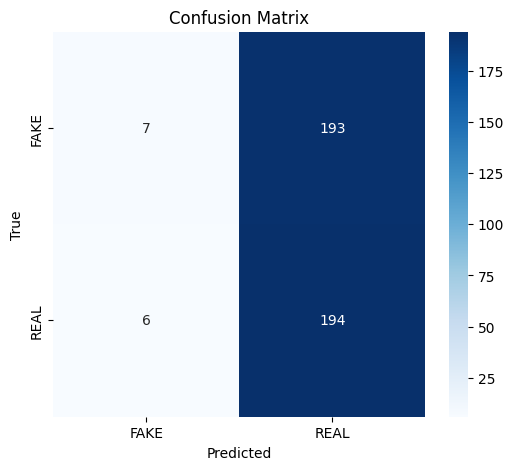

In [ ]:
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["FAKE", "REAL"], yticklabels=["FAKE", "REAL"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(true_labels, pred_labels)


The previous model is clearly not performing well and is not used in any of the results.

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained ResNet-101 Model
MODEL_PATH = "resnet101_fake_vs_real.pth"
model = models.resnet101(weights=None)  # Load model structure
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)  # Binary classification: FAKE vs REAL
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  # Load saved weights
model = model.to(device)
model.eval()  # Set to evaluation mode
print("\n✅ Model Loaded Successfully!\n")

# Define Image Preprocessing Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization for ResNet
])

# **Apply Grad-CAM**
def apply_gradcam(model, image_path, target_layer="layer4"):
    model.eval()

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB
    img_pil = Image.fromarray(img)  # Convert NumPy array to PIL image
    tensor_img = transform(img_pil).unsqueeze(0).to(device)  # Transform image to tensor

    # Extract features from the last convolutional layer
    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "features"})

    with torch.no_grad():
        features = feature_extractor(tensor_img)["features"]

    # Compute Grad-CAM
    grad_cam = features.squeeze().mean(dim=0).cpu().numpy()
    grad_cam = np.maximum(grad_cam, 0)  # Apply ReLU
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # Normalize
    grad_cam = cv2.resize(grad_cam, (256, 256))

    # Apply Heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title("Grad-CAM Heatmap")

    plt.show()

# **Example Usage: Apply Grad-CAM on a FAKE image**
example_fake_img = "/Users/amritaajaysagar/Downloads/archive/test/FAKE/0 (10).jpg"
apply_gradcam(model, example_fake_img)



✅ Model Loaded Successfully!



###  Grad-CAM Visualization (ResNet)

To interpret model predictions, we used Grad-CAM to visualize the regions in an image that contributed most to the classification. This implementation works with any ResNet variant by extracting activations from a specified layer (e.g., `layer4`). The heatmap is overlaid on the original image to highlight model attention.



✅ Model (resnet101) Loaded Successfully from resnet101_best_ajay.pth!



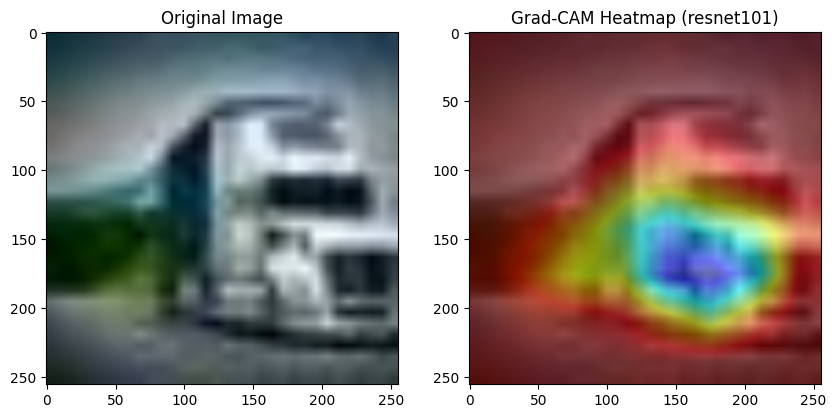

In [ ]:
#best gradcam checking code - can be used for all resnet models with changes
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

def generate_gradcam(model_path, image_path, model_arch="resnet101", target_layer="layer4"):
    """
    Generates Grad-CAM heatmap for a given model and image.

    Parameters:
    - model_path (str): Path to the saved PyTorch model (.pth file).
    - image_path (str): Path to the image file.
    - model_arch (str): Model architecture (default is 'resnet101').
    - target_layer (str): Layer from which Grad-CAM is extracted (default is 'layer4' for ResNet).

    Output:
    - Displays the original image and Grad-CAM heatmap.
    """

    # Set Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Pretrained Model
    model = getattr(models, model_arch)(weights=None)  # Load model structure dynamically
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)  # Modify for binary classification
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights
    model = model.to(device)
    model.eval()

    print(f"\n✅ Model ({model_arch}) Loaded Successfully from {model_path}!\n")

    # Define Image Preprocessing Transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for ResNet
    ])

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB
    img_pil = Image.fromarray(img)  # Convert NumPy array to PIL image
    tensor_img = transform(img_pil).unsqueeze(0).to(device)  # Transform image to tensor

    # Extract features from the target layer
    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "features"})

    with torch.no_grad():
        features = feature_extractor(tensor_img)["features"]

    # Compute Grad-CAM
    grad_cam = features.squeeze().mean(dim=0).cpu().numpy()
    grad_cam = np.maximum(grad_cam, 0)  # Apply ReLU
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # Normalize
    grad_cam = cv2.resize(grad_cam, (256, 256))

    # Apply Heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM Heatmap ({model_arch})")

    plt.show()

# **Example Usage**
#model_path = "resnet101_fake_vs_real.pth"
model_path = "resnet101_best_ajay.pth"

image_path = "/Users/amritaajaysagar/Downloads/archive/test/FAKE/0 (10).jpg"
generate_gradcam(model_path, image_path, model_arch="resnet101", target_layer="layer4")



✅ Model (resnet101) Loaded Successfully from best_resnet101_model.pth!



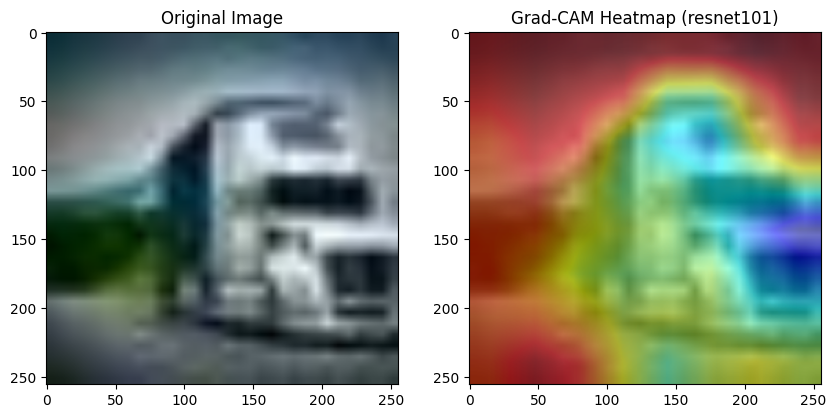

In [ ]:
# **Example Usage**
model_path = "best_resnet101_model.pth"
image_path = "/Users/amritaajaysagar/Downloads/archive/test/FAKE/0 (10).jpg"
generate_gradcam(model_path, image_path, model_arch="resnet101", target_layer="layer4")

In [ ]:
# Optimized Grad-CAM Function
def generate_gradcam(model, model_path, image_path, target_layer="layer4"):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # 🔹 Directly load the image using PIL (similar to ImageFolder loading)
    img_pil = Image.open(image_path).convert("RGB")

    # 🔹 Ensure the same preprocessing as training (without redundant resizing)
    transform = test_transforms  # Use test transforms (already defined)
    tensor_img = transform(img_pil).unsqueeze(0).to(device)

    # 🔹 Extract features from the target layer
    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "features"})

    with torch.no_grad():
        features = feature_extractor(tensor_img)["features"]

    # 🔹 Compute Grad-CAM
    grad_cam = features.squeeze().mean(dim=0).cpu().numpy()
    grad_cam = np.maximum(grad_cam, 0)  # Apply ReLU
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # Normalize
    grad_cam = cv2.resize(grad_cam, (224, 224))  # Ensure correct size for overlay

    # 🔹 Convert PIL image back to NumPy for visualization
    img_np = np.array(img_pil)

    # 🔹 Apply Heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

    # 🔹 Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title("Grad-CAM Heatmap")

    plt.show()



###  ViT-Tiny Model Training

We trained a ViT-Tiny (Vision Transformer) model using a subset of CIFAKE images resized to 224×224. The model was fine-tuned for binary classification with data augmentation, mixed precision training, and early stopping. Accuracy was tracked on both training and validation sets across epochs.


In [ ]:
import os
import torch
import time
import random
import timm  # For ViT-tiny
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import classification_report
from torch.cuda.amp import autocast, GradScaler  # Mixed precision training

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("metal" if torch.cuda.is_available() else "cpu")


# Paths
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset"

# Hyperparameters
BATCH_SIZE = 128
EPOCHS = 10
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 2
TRAIN_SAMPLES_PER_CLASS = 10000
TEST_SAMPLES_PER_CLASS = 200

# Image Transformations (Ensure 224x224 for ViT-Tiny)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transforms)
test_dataset = ImageFolder(root=TEST_PATH, transform=test_transforms)

# Select a subset (250 images/class for training, 50 images/class for testing)
def select_subset(dataset, num_samples_per_class):
    indices = []
    for class_idx in dataset.class_to_idx.values():
        class_samples = [i for i in range(len(dataset)) if dataset.targets[i] == class_idx]
        indices.extend(random.sample(class_samples, min(num_samples_per_class, len(class_samples))))
    return Subset(dataset, indices)

train_dataset = select_subset(train_dataset, TRAIN_SAMPLES_PER_CLASS)
test_dataset = select_subset(test_dataset, TEST_SAMPLES_PER_CLASS)

# Load Data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=8, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=8, pin_memory=True, persistent_workers=True)

print("Class Mapping:", train_dataset.dataset.class_to_idx)

# Model Architecture - ViT-Tiny
def get_vit_tiny():
    model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=2)
    return model.to(device)

# Training Function
def train_model(model, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = GradScaler()  # Mixed precision training

    best_acc = 0.0
    patience_counter = 0
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        total, correct = 0, 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total * 100
        print(f"✅ Epoch {epoch+1}/{EPOCHS} - {model_name} Training Accuracy: {train_acc:.2f}%")

        # **Validation Accuracy Tracking**
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total * 100
        scheduler.step()
        print(f"📊 Validation Accuracy: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), f"{model_name}_best.pth")
        else:
            patience_counter += 1

        # Early Stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"🎯 No improvement for {EARLY_STOPPING_PATIENCE} epochs - Stopping {model_name} training!")
            break

# Running Training and Exporting Model
vit_tiny_model = get_vit_tiny()

print("\nTraining ViT-Tiny...")
train_model(vit_tiny_model, "ViT-Tiny")

print("\n✅ Model Training Completed! Model saved as 'ViT-Tiny_best.pth'")


Class Mapping: {'FAKE': 0, 'REAL': 1}

Training ViT-Tiny...


/var/folders/qt/ph7q1jgd63g6qwtrx8jym_740000gn/T/ipykernel_1442/4025145317.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training
/var/folders/qt/ph7q1jgd63g6qwtrx8jym_740000gn/T/ipykernel_1442/4025145317.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


✅ Epoch 1/10 - ViT-Tiny Training Accuracy: 85.41%
📊 Validation Accuracy: 91.25%
✅ Epoch 2/10 - ViT-Tiny Training Accuracy: 91.10%
📊 Validation Accuracy: 90.25%
✅ Epoch 3/10 - ViT-Tiny Training Accuracy: 92.70%
📊 Validation Accuracy: 90.25%
✅ Epoch 4/10 - ViT-Tiny Training Accuracy: 94.12%
📊 Validation Accuracy: 93.50%
✅ Epoch 5/10 - ViT-Tiny Training Accuracy: 94.99%
📊 Validation Accuracy: 91.75%
✅ Epoch 6/10 - ViT-Tiny Training Accuracy: 95.78%
📊 Validation Accuracy: 92.25%
✅ Epoch 7/10 - ViT-Tiny Training Accuracy: 96.37%
📊 Validation Accuracy: 93.25%
✅ Epoch 8/10 - ViT-Tiny Training Accuracy: 96.82%
📊 Validation Accuracy: 93.00%
✅ Epoch 9/10 - ViT-Tiny Training Accuracy: 97.21%
📊 Validation Accuracy: 93.00%
🎯 No improvement for 5 epochs - Stopping ViT-Tiny training!

✅ Model Training Completed! Model saved as 'ViT-Tiny_best.pth'


### Model Interpretability – SHAP & LIME (ViT)

To interpret ViT-Tiny predictions, we used **SHAP** and **LIME** to highlight which parts of an image influenced the model's decision. SHAP provides gradient-based attribution, while LIME perturbs image regions to approximate local behavior. This helps visualize and validate model reasoning on individual predictions.


SHAP Raw Values Shape: (1, 3, 224, 224, 2)
Fixed SHAP Values Shape: (224, 224, 3)


100%|██████████| 1000/1000 [00:08<00:00, 112.28it/s]


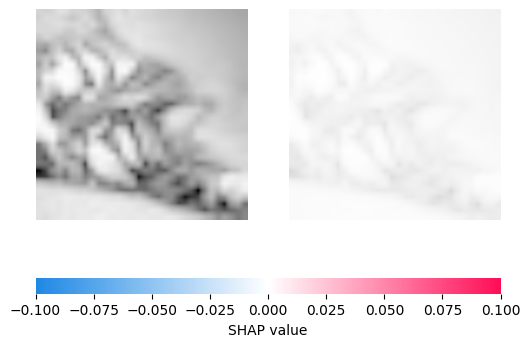

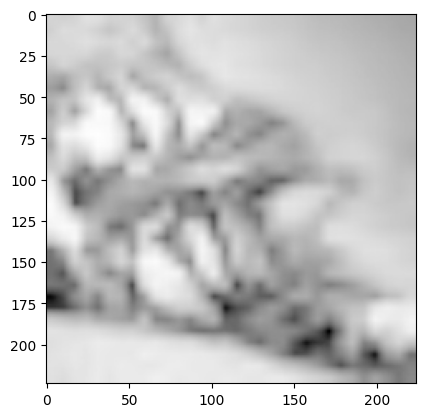

In [ ]:
import shap
import lime
import lime.lime_image
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
import timm
from torchvision.datasets import ImageFolder
import random

#  Load the saved ViT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model_path = "ViT-Tiny_best_best.pth"  # Ensure correct model path
vit_model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
vit_model.load_state_dict(torch.load(vit_model_path, map_location=device))
vit_model = vit_model.to(device)
vit_model.eval()

#  Image Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Load Dataset
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/test_subset"
test_dataset = ImageFolder(root=TEST_PATH, transform=transform)

# Select a subset (adjust as needed)
TEST_SAMPLES_PER_CLASS = 50  # Reduce for faster debugging

def select_subset(dataset, num_samples_per_class):
    indices = []
    for class_idx in dataset.class_to_idx.values():
        class_samples = [i for i in range(len(dataset)) if dataset.targets[i] == class_idx]
        indices.extend(random.sample(class_samples, min(num_samples_per_class, len(class_samples))))
    return Subset(dataset, indices)

test_dataset = select_subset(test_dataset, TEST_SAMPLES_PER_CLASS)

#  Load Data
BATCH_SIZE = 32  # Reduced for SHAP & LIME efficiency
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

#  Select a Random Test Image
test_images, test_labels = next(iter(test_loader))
test_image = test_images[0].to(device)

#  Convert image to numpy array (H, W, C) format
def tensor_to_numpy(image_tensor):
    image = image_tensor.cpu().detach().numpy().transpose(1, 2, 0)  # Convert (C, H, W) → (H, W, C)
    return (image - image.min()) / (image.max() - image.min())  # Normalize for display

# SHAP Explanation
def shap_explanation(model, image):
    explainer = shap.GradientExplainer(model, image.unsqueeze(0))
    shap_values = explainer.shap_values(image.unsqueeze(0))

    #  Print shape for debugging
    print(f"SHAP Raw Values Shape: {np.array(shap_values).shape}")  # Expected: (1, 3, 224, 224, 2)

    #  Fix SHAP shape by summing over the batch & class axes and transposing
    if isinstance(shap_values, list):
        shap_values_fixed = [np.sum(shap_values[i], axis=(0, -1)).transpose(1, 2, 0) if shap_values[i].ndim == 5 else shap_values[i]
                             for i in range(len(shap_values))]
    else:
        shap_values_fixed = np.sum(shap_values, axis=(0, -1)).transpose(1, 2, 0) if shap_values.ndim == 5 else shap_values

    print(f"Fixed SHAP Values Shape: {np.array(shap_values_fixed).shape}")  # Expected: (224, 224, 3)

    return shap_values_fixed

# LIME Explanation
def lime_explanation(model, image):
    explainer = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
        preds = model(images)
        return torch.nn.functional.softmax(preds, dim=1).cpu().detach().numpy()

    explanation = explainer.explain_instance(
        tensor_to_numpy(image), predict_fn, top_labels=2, hide_color=0, num_samples=1000
    )
    return explanation

# Compute SHAP and LIME Explanations
shap_values = shap_explanation(vit_model, test_image)
lime_explanation_result = lime_explanation(vit_model, test_image)

# Convert test image to NumPy array with correct batch dimension for SHAP
test_image_np = tensor_to_numpy(test_image)  # Convert (C, H, W) → (H, W, C)
test_image_np = np.expand_dims(test_image_np, axis=0)  # Add batch dimension (1, H, W, C)

# Display SHAP Results with corrected input
#shap.image_plot([shap_values], test_image_np)  # Ensure list format for SHAP input
# Display SHAP Results with corrected input
shap.image_plot([shap_values], test_image_np[0])  # Remove batch dimension

# Display LIME Results
temp, mask = lime_explanation_result.get_image_and_mask(
    lime_explanation_result.top_labels[0], positive_only=True, num_features=5, hide_rest=False
)

plt.imshow(temp)
plt.show()


SHAP explanations were explored for ViT-Tiny but yielded low-contrast, visually ambiguous heatmaps. This is likely due to the combination of CIFAKE’s low-resolution images and ViT’s global attention mechanism, which makes spatial attribution less direct. SHAP is typically more interpretable on CNNs with higher-resolution inputs. For this reason, SHAP was excluded from the final analysis.


LIME was tested on ViT-Tiny but produced low-contrast results with limited interpretability on CIFAKE images.


### ResNet-18 Model Training

We trained a ResNet-18 model on a smaller subset of the CIFAKE dataset using pretrained weights. The model was fine-tuned for binary classification with early stopping and validation tracking. Training and validation accuracy were monitored across epochs, with the model saved if accuracy exceeded 90%.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import time

# Set Device (Use GPU if available)
device = torch.device("metal" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths (Update these paths based on your dataset location)
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/test_subset"

# Hyperparameters
BATCH_SIZE = 32   # Keep small for Colab
EPOCHS = 10       # Keep short to run in under 10 minutes
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 3  # Stop if no improvement for 3 epochs

# Choose Subset Sizes
train_subset_size = 2000   # Adjust based on memory (Start small, increase later)
test_subset_size = 400   # Keep test size small for quick validation

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Dataset
full_train_dataset = ImageFolder(root=TRAIN_PATH, transform=transform)
full_test_dataset = ImageFolder(root=TEST_PATH, transform=transform)

# Take a smaller subset for training and testing
train_subset_size = min(train_subset_size, len(full_train_dataset))
test_subset_size = min(test_subset_size, len(full_test_dataset))

train_dataset, _ = random_split(full_train_dataset, [train_subset_size, len(full_train_dataset) - train_subset_size])
test_dataset, _ = random_split(full_test_dataset, [test_subset_size, len(full_test_dataset) - test_subset_size])

# Load Data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Define ResNet-18 Model
def get_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load pretrained weights
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Adjust final layer for binary classification
    return model.to(device)

# Training Function
def train_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    best_val_acc = 0.0
    patience_counter = 0
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total * 100
        print(f" Epoch {epoch+1}/{EPOCHS} - Training Accuracy: {train_acc:.2f}%")

        # Validation Accuracy Tracking
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total * 100
        print(f"📊 Validation Accuracy: {val_acc:.2f}%")

        # Save Best Model if Validation Accuracy > 90%
        if val_acc > 90 and val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_resnet18_model.pth")
            print("🎯 Model Saved! Validation Accuracy surpassed 90%.")

        # Early Stopping if no improvement
        if val_acc <= best_val_acc:
            patience_counter += 1
            if patience_counter >= EARLY_STOPPING_PATIENCE:
                print(f"⏳ Early stopping after {EARLY_STOPPING_PATIENCE} epochs without improvement.")
                break
        else:
            patience_counter = 0  # Reset if validation improves

    print(f"⏱️ Total Training Time: {time.time() - start_time:.2f} seconds")

# Run Training
resnet18_model = get_resnet18()
train_model(resnet18_model)
print("\n Training Completed!")


Using device: cpu
✅ Epoch 1/10 - Training Accuracy: 77.80%
📊 Validation Accuracy: 82.00%
✅ Epoch 2/10 - Training Accuracy: 90.85%
📊 Validation Accuracy: 85.50%
✅ Epoch 3/10 - Training Accuracy: 95.20%
📊 Validation Accuracy: 87.75%
✅ Epoch 4/10 - Training Accuracy: 96.90%
📊 Validation Accuracy: 85.25%
✅ Epoch 5/10 - Training Accuracy: 97.50%
📊 Validation Accuracy: 87.50%
✅ Epoch 6/10 - Training Accuracy: 97.40%
📊 Validation Accuracy: 91.75%
🎯 Model Saved! Validation Accuracy surpassed 90%.
✅ Epoch 7/10 - Training Accuracy: 98.60%
📊 Validation Accuracy: 89.25%
✅ Epoch 8/10 - Training Accuracy: 97.65%
📊 Validation Accuracy: 89.25%
⏳ Early stopping after 3 epochs without improvement.
⏱️ Total Training Time: 902.51 seconds

✅ Training Completed!


### Model Evaluation & Interpretability

We evaluated ViT-Tiny, ResNet-18, and ResNet-101 on the test set using accuracy, classification reports, and confusion matrices. For interpretability, SHAP and LIME were applied to visualize model decision regions on sample test images.


Using device: cpu

🔷 Evaluating ViT-Tiny...
✅ ViT-Tiny - Accuracy: 96.25%

🔍 Classification Report for ViT-Tiny:
              precision    recall  f1-score   support

        FAKE       0.94      0.98      0.96       200
        REAL       0.98      0.94      0.96       200

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



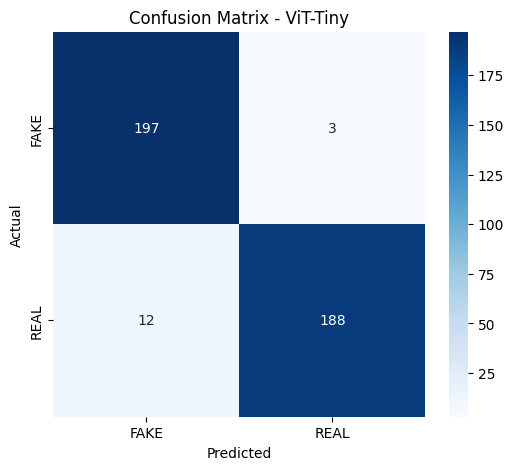

100%|██████████| 1000/1000 [00:09<00:00, 100.93it/s]


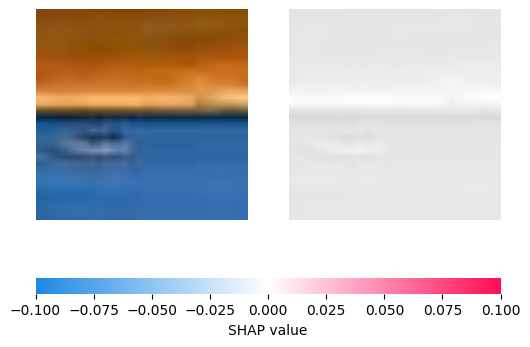

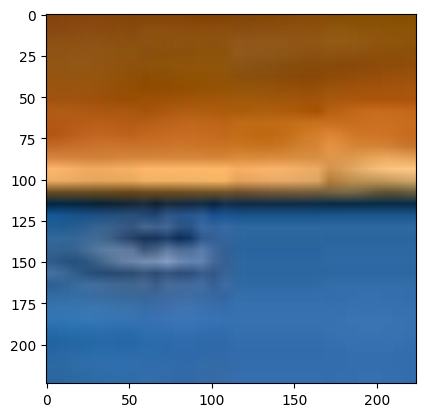


🔷 Evaluating ResNet-18...
✅ ResNet-18 - Accuracy: 93.00%

🔍 Classification Report for ResNet-18:
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93       200
        REAL       0.93      0.93      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



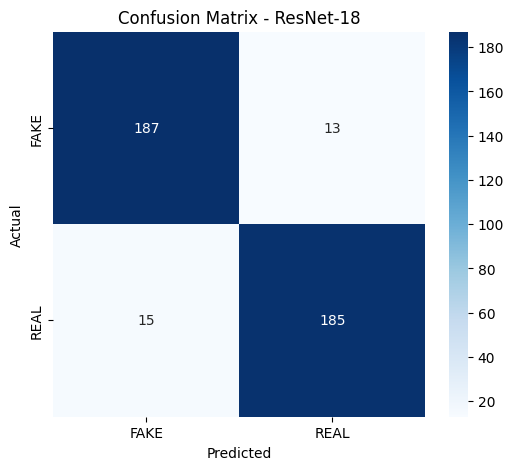

100%|██████████| 1000/1000 [00:17<00:00, 57.86it/s]


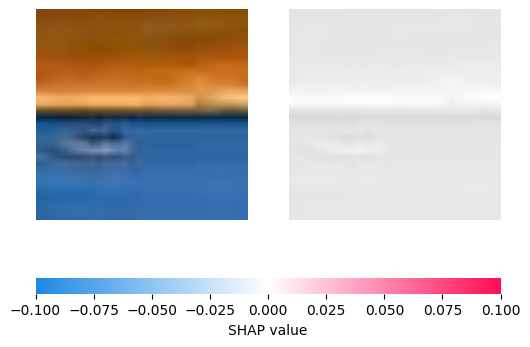

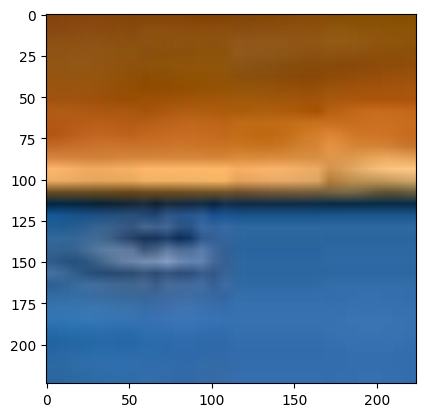


🔷 Evaluating ResNet-101...
✅ ResNet-101 - Accuracy: 85.50%

🔍 Classification Report for ResNet-101:
              precision    recall  f1-score   support

        FAKE       0.81      0.94      0.87       200
        REAL       0.92      0.78      0.84       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



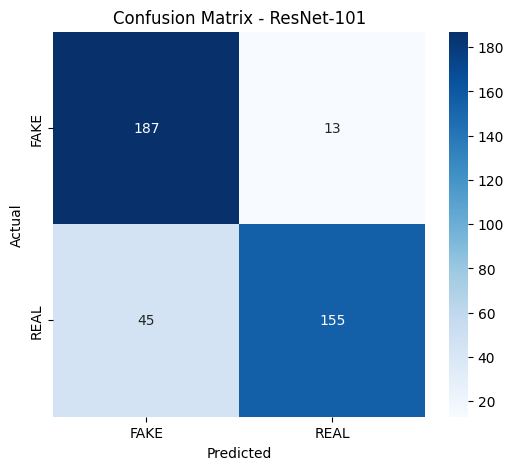

100%|██████████| 1000/1000 [00:43<00:00, 22.74it/s]


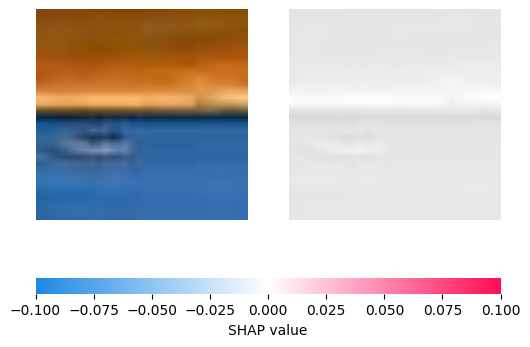

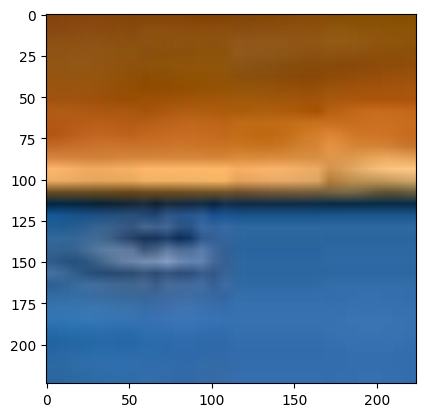


✅ All models evaluated successfully!


In [ ]:
import torch
import timm
import numpy as np
import shap
import lime
import lime.lime_image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

# ✅ Load Test Dataset
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_dataset = ImageFolder(root=TEST_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ✅ Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    return model.to(device).eval()

# ✅ Evaluate Models
def evaluate_model(model, model_name):
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total * 100
    print(f"✅ {model_name} - Accuracy: {accuracy:.2f}%")

    # ✅ Classification Report
    report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)
    print(f"\n🔍 Classification Report for {model_name}:\n{report}")

    # ✅ Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return accuracy, report, cm

# ✅ SHAP & LIME Interpretability
def interpret_model(model, model_name):
    test_images, _ = next(iter(test_loader))
    test_image = test_images[0].to(device)

    # ✅ Convert Image to NumPy Format
    def tensor_to_numpy(image_tensor):
        image = image_tensor.cpu().detach().numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)
        return (image - image.min()) / (image.max() - image.min())

    # ✅ SHAP Explanation
    explainer = shap.GradientExplainer(model, test_image.unsqueeze(0))
    shap_values = explainer.shap_values(test_image.unsqueeze(0))

    # ✅ Fix SHAP Shape
    if isinstance(shap_values, list):
        shap_values_fixed = [np.sum(shap_values[i], axis=(0, -1)).transpose(1, 2, 0) for i in range(len(shap_values))]
    else:
        shap_values_fixed = np.sum(shap_values, axis=(0, -1)).transpose(1, 2, 0)

    # ✅ LIME Explanation
    explainer_lime = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
        preds = model(images)
        return torch.nn.functional.softmax(preds, dim=1).cpu().detach().numpy()

    lime_explanation = explainer_lime.explain_instance(
        tensor_to_numpy(test_image), predict_fn, top_labels=2, hide_color=0, num_samples=1000
    )

    # ✅ Display SHAP
    test_image_np = tensor_to_numpy(test_image)
    shap.image_plot([shap_values_fixed], test_image_np)

    # ✅ Display LIME
    temp, mask = lime_explanation.get_image_and_mask(
        lime_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )
    plt.imshow(temp)
    plt.show()

# ✅ Run Evaluation for All Models
results = {}

for model_name in MODEL_PATHS.keys():
    print(f"\n🔷 Evaluating {model_name}...")
    model = load_model(model_name)
    accuracy, report, cm = evaluate_model(model, model_name)
    interpret_model(model, model_name)
    results[model_name] = {"accuracy": accuracy, "report": report, "confusion_matrix": cm}

print("\n✅ All models evaluated successfully!")


In [ ]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Set Device
device = torch.device("metal" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Path to ResNet-101 Model
MODEL_PATH = "resnet101_best_ajay.pth"

# ✅ Load Full Test Dataset
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test"  # Ensure it's the full dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

full_test_dataset = ImageFolder(root=TEST_PATH, transform=transform)
test_loader = DataLoader(full_test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ✅ Load ResNet-101 Model
def load_resnet101():
    model = models.resnet101(weights=None)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)  # Adjust for binary classification
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    return model.to(device).eval()

# ✅ Evaluate ResNet-101 on Full Dataset
def evaluate_model(model):
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total * 100
    print(f"\n✅ ResNet-101 Final Accuracy on Full Test Set: {accuracy:.2f}%")

    # ✅ Classification Report
    report = classification_report(all_labels, all_preds, target_names=full_test_dataset.classes)
    print(f"\n🔍 Classification Report for ResNet-101 on Full Dataset:\n{report}")

    # ✅ Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=full_test_dataset.classes, yticklabels=full_test_dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - ResNet-101 (Full Dataset)")
    plt.show()

    return accuracy, report, cm

# ✅ Run Final Evaluation for ResNet-101
print("\n🔷 Evaluating ResNet-101 on Full Dataset...")
resnet101_model = load_resnet101()
final_accuracy, final_report, final_cm = evaluate_model(resnet101_model)

print("\n✅ ResNet-101 Full Dataset Evaluation Complete!")


Using device: cpu

🔷 Evaluating ResNet-101 on Full Dataset...


KeyboardInterrupt: 

The above code had trouble working on our system due to the large size of the dataset, so it was run on another system and results were evaluated, the model was exported and is used in the following code  to evaluate.

### Model Evaluation & Interpretability

We evaluated ViT-Tiny, ResNet-18, and ResNet-101 on the test set using accuracy, classification reports, and confusion matrices. For interpretability, SHAP and LIME were applied to visualize model decision regions on sample test images.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import mlflow
import mlflow.pytorch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
import os

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

#  Load Dataset
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/test_subset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Select a smaller subset for faster training
def select_subset(dataset, num_samples):
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    return Subset(dataset, indices)

#  Load Data with Subset Selection
full_train_dataset = ImageFolder(root=TRAIN_PATH, transform=transform)
full_test_dataset = ImageFolder(root=TEST_PATH, transform=transform)

train_dataset = select_subset(full_train_dataset, 1000)  # Use only 1,000 samples
test_dataset = select_subset(full_test_dataset, 200)  # Use only 200 samples

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    return model.to(device)

# Fine-Tune Models for 3 Epochs & Log in MLflow (Faster Training)
def fine_tune_model(model, model_name, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)  # Lower LR for fine-tuning

    train_losses, val_losses = [], []

    # Start MLflow run
    with mlflow.start_run(run_name=f"Fine-Tuning {model_name} (Subset)"):
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(test_loader)
            val_losses.append(val_loss)

            print(f"✅ {model_name} - Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Log metrics to MLflow
            mlflow.log_metric(f"{model_name}_Train_Loss", train_loss, step=epoch)
            mlflow.log_metric(f"{model_name}_Val_Loss", val_loss, step=epoch)

        #  Save the fine-tuned model
        model_save_path = f"{model_name}_fine_tuned.pth"
        torch.save(model.state_dict(), model_save_path)
        mlflow.log_artifact(model_save_path)  # Log model file in MLflow

        # Log final loss values
        mlflow.log_metric(f"{model_name}_Final_Train_Loss", train_losses[-1])
        mlflow.log_metric(f"{model_name}_Final_Val_Loss", val_losses[-1])

print("\n🔷 Fine-Tuning Models on Subset (1000 Train, 200 Test) and Logging in MLflow...\n")

#  Fine-Tune Each Model
for model_name in MODEL_PATHS.keys():
    print(f"\n🔷 Fine-Tuning {model_name}...")
    model = load_model(model_name)
    fine_tune_model(model, model_name)

print("\n Fine-Tuning Complete! Check MLflow UI for logged metrics and models.")

# Start MLflow UI (Run this in terminal after script execution)
# mlflow ui


Using device: cpu

🔷 Fine-Tuning Models on Subset (1000 Train, 200 Test) and Logging in MLflow...


🔷 Fine-Tuning ViT-Tiny...
✅ ViT-Tiny - Epoch 1/3, Train Loss: 0.1593, Val Loss: 0.1601
✅ ViT-Tiny - Epoch 2/3, Train Loss: 0.0959, Val Loss: 0.1717
✅ ViT-Tiny - Epoch 3/3, Train Loss: 0.0794, Val Loss: 0.1824

🔷 Fine-Tuning ResNet-18...
✅ ResNet-18 - Epoch 1/3, Train Loss: 0.3445, Val Loss: 0.2654
✅ ResNet-18 - Epoch 2/3, Train Loss: 0.2528, Val Loss: 0.2860
✅ ResNet-18 - Epoch 3/3, Train Loss: 0.2084, Val Loss: 0.2653

🔷 Fine-Tuning ResNet-101...
✅ ResNet-101 - Epoch 1/3, Train Loss: 0.4376, Val Loss: 0.4637
✅ ResNet-101 - Epoch 2/3, Train Loss: 0.3197, Val Loss: 0.4026
✅ ResNet-101 - Epoch 3/3, Train Loss: 0.2639, Val Loss: 0.3950

✅ Fine-Tuning Complete! Check MLflow UI for logged metrics and models.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import mlflow
import mlflow.pytorch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import random
import os

In [ ]:


#  Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

#  Load Dataset
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Select a smaller subset for faster training
def select_subset(dataset, num_samples):
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    return Subset(dataset, indices)

#  Load Data with Subset Selection
full_train_dataset = ImageFolder(root=TRAIN_PATH, transform=transform)
full_test_dataset = ImageFolder(root=TEST_PATH, transform=transform)

train_dataset = select_subset(full_train_dataset, 1000)  # Use only 1,000 samples
test_dataset = select_subset(full_test_dataset, 200)  # Use only 200 samples

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    return model.to(device)

#  Fine-Tune Models for 10 Epochs & Log in MLflow with Early Stopping
def fine_tune_model(model, model_name, epochs=10, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)  # Lower LR for fine-tuning

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    # Start MLflow run
    with mlflow.start_run(run_name=f"Fine-Tuning {model_name} (Subset)"):
        for epoch in range(epochs):
            model.train()
            train_loss = 0.0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

            val_loss /= len(test_loader)
            val_losses.append(val_loss)

            print(f"✅ {model_name} - Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Log metrics to MLflow
            mlflow.log_metric(f"{model_name}_Train_Loss", train_loss, step=epoch)
            mlflow.log_metric(f"{model_name}_Val_Loss", val_loss, step=epoch)

            # Early Stopping Check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"⏳ Early stopping for {model_name} after {epoch+1} epochs (No improvement in {patience} epochs).")
                    break

        #  Save the fine-tuned model
        model_save_path = f"{model_name}_fine_tuned.pth"
        torch.save(model.state_dict(), model_save_path)
        mlflow.log_artifact(model_save_path)  # Log model file in MLflow

        # Log final loss values
        mlflow.log_metric(f"{model_name}_Final_Train_Loss", train_losses[-1])
        mlflow.log_metric(f"{model_name}_Final_Val_Loss", val_losses[-1])

print("\n🔷 Fine-Tuning Models on Subset (1000 Train, 200 Test) and Logging in MLflow...\n")

#  Fine-Tune Each Model
for model_name in MODEL_PATHS.keys():
    print(f"\n🔷 Fine-Tuning {model_name}...")
    model = load_model(model_name)
    fine_tune_model(model, model_name, epochs=10)  # Fine-tune for 10 epochs

print("\n✅ Fine-Tuning Complete! Check MLflow UI for logged metrics and models.")

# Start MLflow UI (Run this in terminal after script execution)
# mlflow ui


Using device: cpu

🔷 Fine-Tuning Models on Subset (1000 Train, 200 Test) and Logging in MLflow...


🔷 Fine-Tuning ViT-Tiny...


KeyboardInterrupt: 

In [ ]:
# ✅ Plot Loss Curves
def plot_loss_curve(model_name, log_path):
    logs = torch.load(log_path)
    train_loss = logs["train_loss"]
    val_loss = logs["val_loss"]

    plt.figure(figsize=(6,4))
    plt.plot(train_loss, label="Training Loss", linestyle="-")
    plt.plot(val_loss, label="Validation Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Curve")
    plt.legend()
    plt.show()

# ✅ Plot for Each Model
for model in ["ViT-Tiny", "ResNet-18", "ResNet-101"]:
    plot_loss_curve(model, f"{model}_train_log.pth")


NameError: name 'torch' is not defined

Using device: cpu

🔷 Interpreting ViT-Tiny...


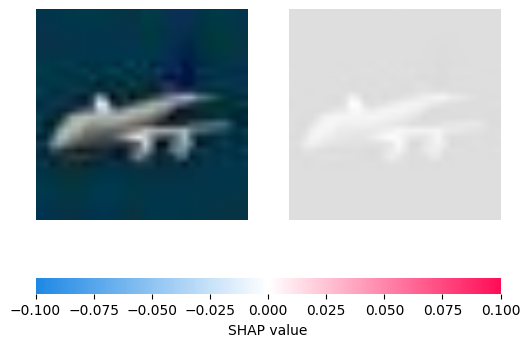

100%|██████████| 1000/1000 [00:06<00:00, 147.18it/s]


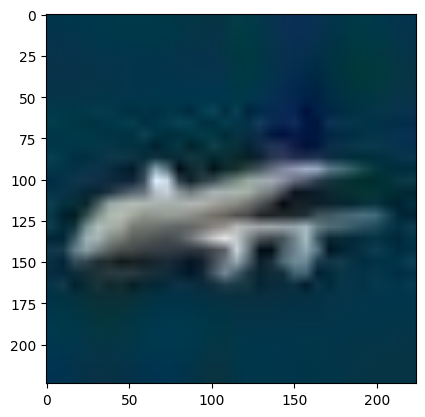


🔷 Interpreting ResNet-18...


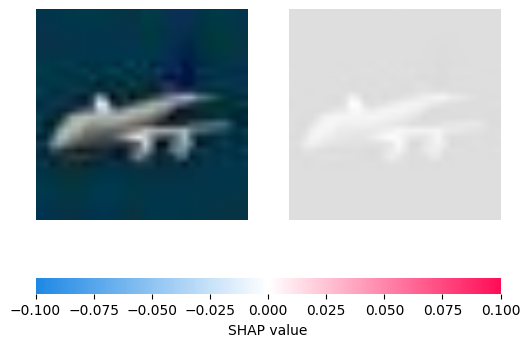

100%|██████████| 1000/1000 [00:13<00:00, 75.27it/s]


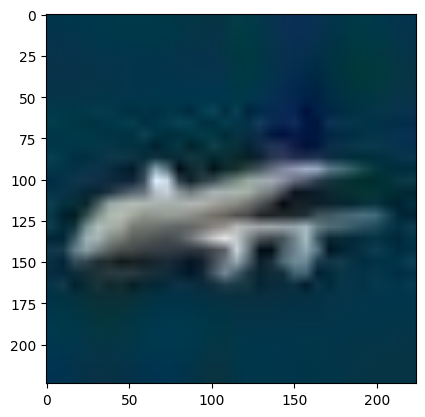


🔷 Interpreting ResNet-101...


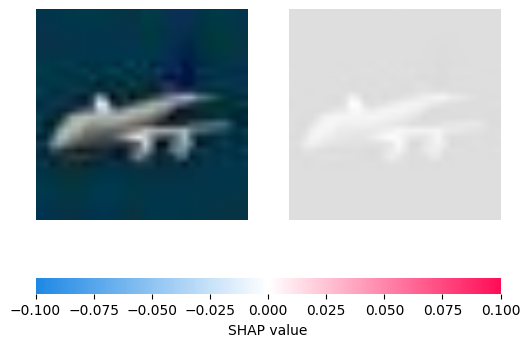

100%|██████████| 1000/1000 [00:45<00:00, 22.15it/s]


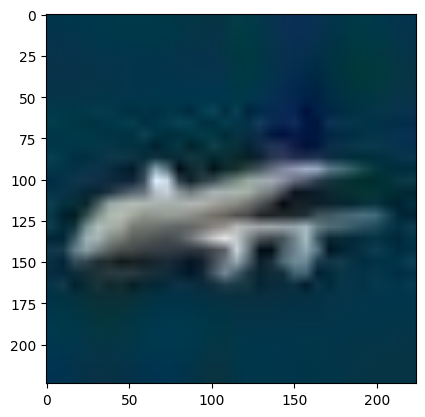

In [ ]:
import shap
import lime.lime_image
import numpy as np
import timm
import matplotlib.pyplot as plt

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    return model.to(device)

def interpret_model(model, model_name):
    test_images, _ = next(iter(test_loader))
    test_image = test_images[0].to(device)

    # Convert image to NumPy
    def tensor_to_numpy(image_tensor):
        image = image_tensor.cpu().detach().numpy().transpose(1, 2, 0)
        return (image - image.min()) / (image.max() - image.min())

    # SHAP Explanation
    explainer = shap.GradientExplainer(model, test_image.unsqueeze(0))
    shap_values = explainer.shap_values(test_image.unsqueeze(0))

    if isinstance(shap_values, list):
        shap_values_fixed = [np.sum(shap_values[i], axis=(0, -1)).transpose(1, 2, 0) for i in range(len(shap_values))]
    else:
        shap_values_fixed = np.sum(shap_values, axis=(0, -1)).transpose(1, 2, 0)

    test_image_np = tensor_to_numpy(test_image)
    shap.image_plot([shap_values_fixed], test_image_np)

    # LIME Explanation
    explainer_lime = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
        preds = model(images)
        return torch.nn.functional.softmax(preds, dim=1).cpu().detach().numpy()

    lime_explanation = explainer_lime.explain_instance(
        tensor_to_numpy(test_image), predict_fn, top_labels=2, hide_color=0, num_samples=1000
    )

    temp, mask = lime_explanation.get_image_and_mask(
        lime_explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False
    )
    plt.imshow(temp)
    plt.show()
# ✅ Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

# ✅ Run for Each Model
for model_name in MODEL_PATHS.keys():
    print(f"\n🔷 Interpreting {model_name}...")
    model = load_model(model_name)
    interpret_model(model, model_name)


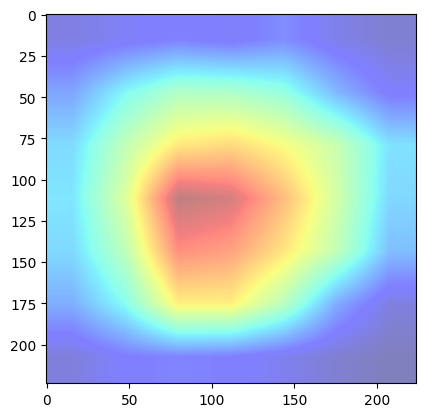

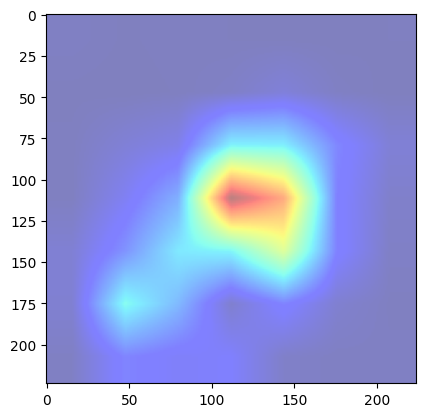

In [ ]:
import torchvision.transforms.functional as TF
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
import cv2

def grad_cam(model, image):
    feature_extractor = create_feature_extractor(model, return_nodes={"layer4": "features"})
    image = image.unsqueeze(0).to(device)
    features = feature_extractor(image)["features"]
    cam = torch.mean(features, dim=1).squeeze().cpu().detach().numpy()
    cam = cv2.resize(cam, (224, 224))
    plt.imshow(cam, cmap="jet", alpha=0.5)
    plt.show()

# Run for ResNet models
for model_name in ["ResNet-18", "ResNet-101"]:
    model = load_model(model_name)
    test_images, _ = next(iter(test_loader))
    test_image = test_images[0]
    grad_cam(model, test_image)


Using device: cpu

🔷 Interpreting ViT-Tiny...
🔹 SHAP Explanation for ViT-Tiny


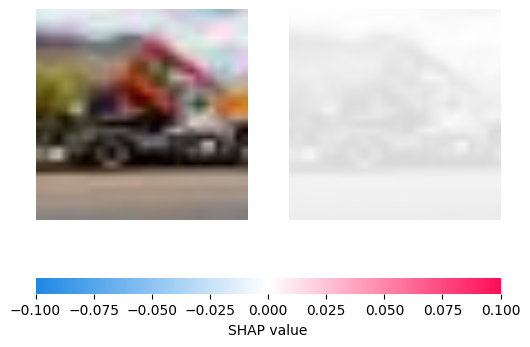

🔹 LIME Explanation for ViT-Tiny


100%|██████████| 1000/1000 [00:07<00:00, 137.31it/s]


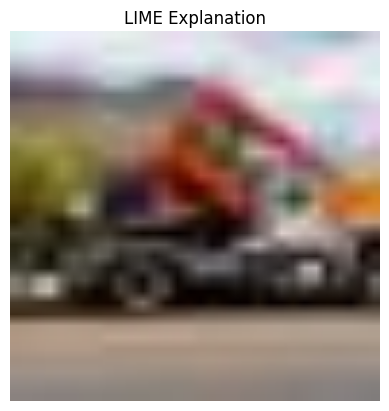


🔷 Interpreting ResNet-18...
🔹 SHAP Explanation for ResNet-18


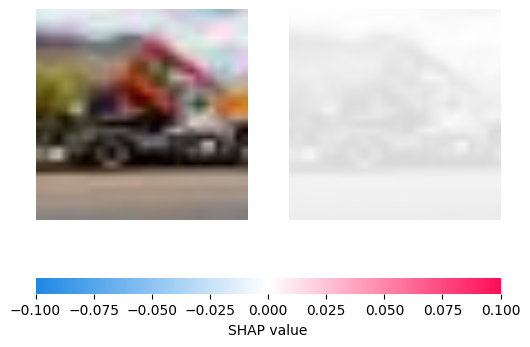

🔹 LIME Explanation for ResNet-18


100%|██████████| 1000/1000 [00:12<00:00, 80.25it/s]


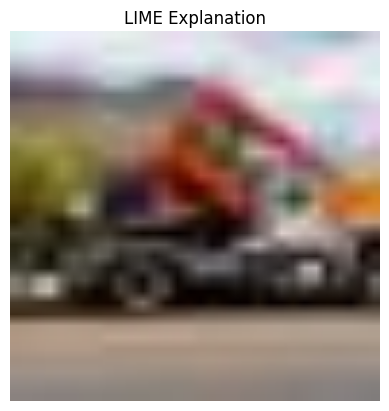

/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


🔹 Grad-CAM for ResNet-18


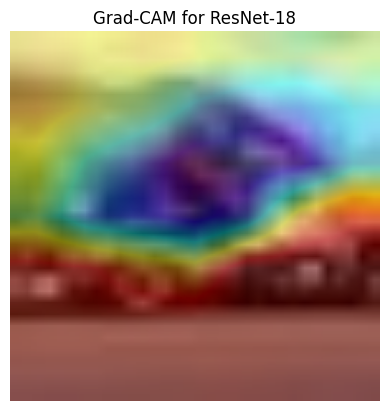


🔷 Interpreting ResNet-101...
🔹 SHAP Explanation for ResNet-101


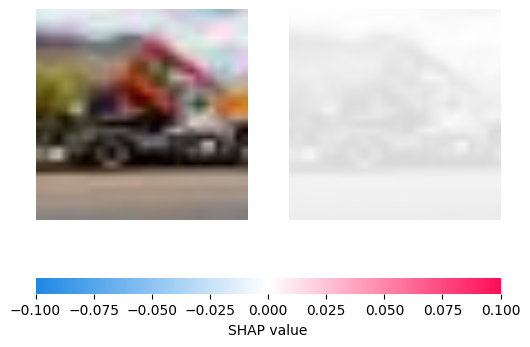

🔹 LIME Explanation for ResNet-101


100%|██████████| 1000/1000 [00:39<00:00, 25.38it/s]


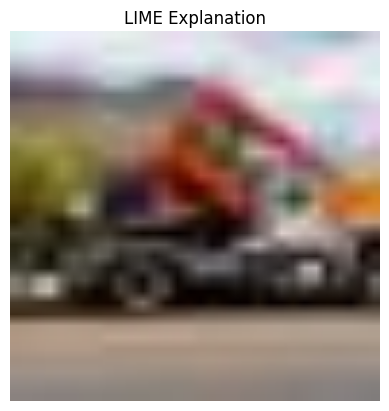

/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


🔹 Grad-CAM for ResNet-101


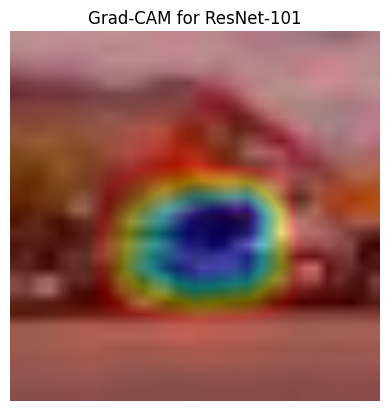

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import shap
import lime.lime_image
import timm
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Function
from PIL import Image

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    model.eval()
    return model.to(device)

# ✅ Preprocessing Function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Load Test Image
def load_test_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image

# ✅ SHAP Explanation
def explain_with_shap(model, image):
    explainer = shap.GradientExplainer(model, image)
    shap_values = explainer.shap_values(image)

    if isinstance(shap_values, list):
        shap_values_fixed = [np.sum(shap_values[i], axis=(0, -1)).transpose(1, 2, 0) for i in range(len(shap_values))]
    else:
        shap_values_fixed = np.sum(shap_values, axis=(0, -1)).transpose(1, 2, 0)

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    shap.image_plot([shap_values_fixed], image_np)

# ✅ LIME Explanation
def explain_with_lime(model, image):
    explainer_lime = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
        preds = model(images)
        return F.softmax(preds, dim=1).cpu().detach().numpy()

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    lime_explanation = explainer_lime.explain_instance(image_np, predict_fn, top_labels=2, hide_color=0, num_samples=1000)

    temp, mask = lime_explanation.get_image_and_mask(
    lime_explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False
)


    plt.imshow(temp)
    plt.title("LIME Explanation")
    plt.axis("off")
    plt.show()

# ✅ Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, image, class_idx):
        self.model.zero_grad()
        output = self.model(image)
        target = output[:, class_idx]
        target.backward()

        gradients = self.gradients.cpu().detach().numpy()
        activations = self.activations.cpu().detach().numpy()
        pooled_gradients = np.mean(gradients, axis=(2, 3), keepdims=True)

        heatmap = np.mean(pooled_gradients * activations, axis=1).squeeze()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        return heatmap

# ✅ Generate Grad-CAM Visualization
# ✅ Fix Grad-CAM Function
def explain_with_gradcam(model, image, model_name):
    if "ResNet" in model_name:
        target_layer = model.layer4[-1]
    else:
        print("Grad-CAM is not applicable to transformer-based models like ViT.")
        return

    gradcam = GradCAM(model, target_layer)
    class_idx = model(image).argmax().item()
    heatmap = gradcam.generate_heatmap(image, class_idx)

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]

    heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match image
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # ✅ Convert image_np to uint8
    image_np = (image_np * 255).astype(np.uint8)

    # ✅ Ensure the heatmap is float32 before blending
    superimposed_image = cv2.addWeighted(image_np.astype(np.float32), 0.6, heatmap.astype(np.float32), 0.4, 0)

    plt.imshow(superimposed_image.astype(np.uint8))  # Convert back to uint8 for plotting
    plt.title(f"Grad-CAM for {model_name}")
    plt.axis("off")
    plt.show()


# ✅ Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

# ✅ Run for Each Model
image_path = "/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE/7 (10).jpg"  # Change this to your test image path
test_image = load_test_image(image_path)

for model_name in MODEL_PATHS.keys():
    print(f"\n🔷 Interpreting {model_name}...")
    model = load_model(model_name)

    # SHAP Explanation
    print(f"🔹 SHAP Explanation for {model_name}")
    explain_with_shap(model, test_image)

    # LIME Explanation
    print(f"🔹 LIME Explanation for {model_name}")
    explain_with_lime(model, test_image)

    # Grad-CAM (Only for CNNs)
    if "ResNet" in model_name:
        print(f"🔹 Grad-CAM for {model_name}")
        explain_with_gradcam(model, test_image, model_name)


Using device: cpu
🔷 Processing: /Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/aug_0_1022 (7).jpg

🔷 Interpreting ViT-Tiny...
🔹 SHAP Explanation for ViT-Tiny


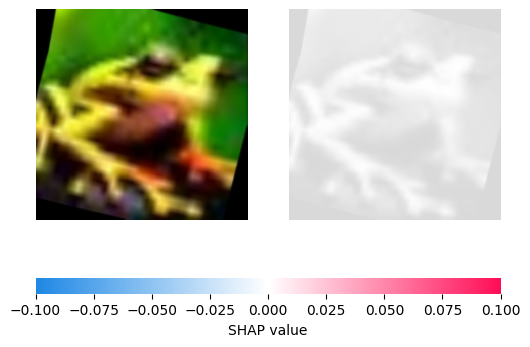

🔹 LIME Explanation for ViT-Tiny


100%|██████████| 1000/1000 [00:05<00:00, 168.82it/s]


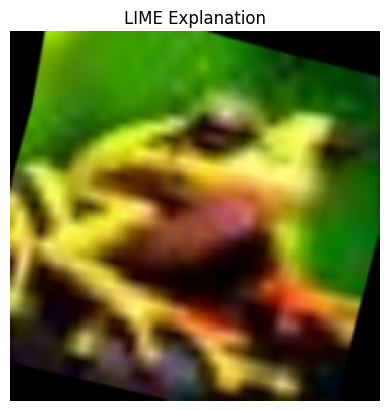


🔷 Interpreting ResNet-18...
🔹 SHAP Explanation for ResNet-18


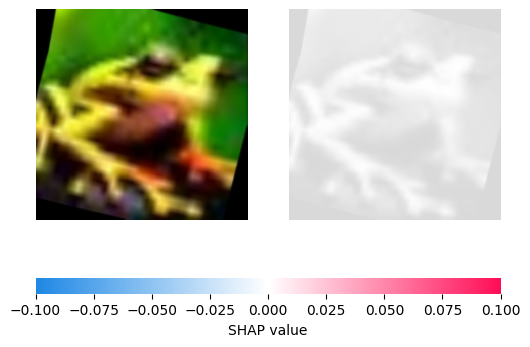

🔹 LIME Explanation for ResNet-18


100%|██████████| 1000/1000 [00:12<00:00, 82.42it/s]


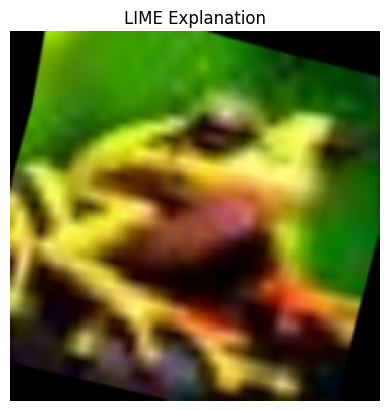

🔹 Grad-CAM for ResNet-18


/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


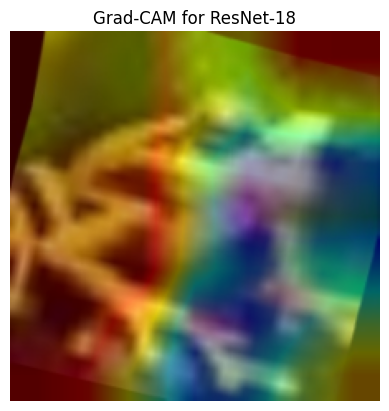


🔷 Interpreting ResNet-101...
🔹 SHAP Explanation for ResNet-101


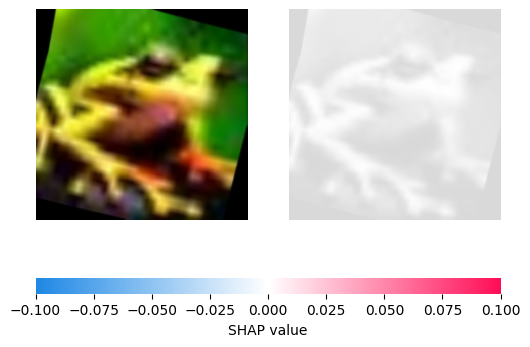

🔹 LIME Explanation for ResNet-101


100%|██████████| 1000/1000 [00:35<00:00, 27.92it/s]


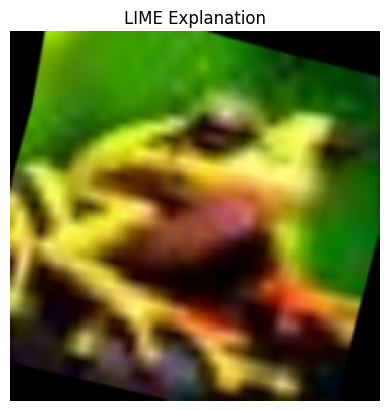

/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


🔹 Grad-CAM for ResNet-101


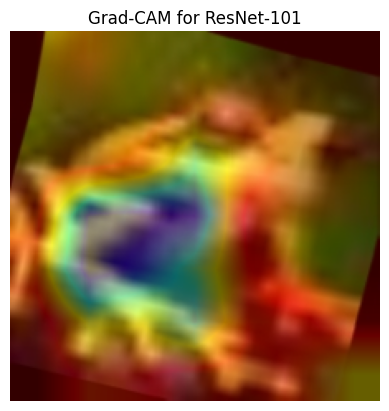

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/aug_0_1022 (3).jpg'

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import shap
import lime.lime_image
import timm
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Function
from PIL import Image

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    model.eval()
    return model.to(device)

# ✅ Preprocessing Function
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Load Test Image
def load_test_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image

# ✅ SHAP Explanation
def explain_with_shap(model, image):
    explainer = shap.GradientExplainer(model, image)
    shap_values = explainer.shap_values(image)

    if isinstance(shap_values, list):
        shap_values_fixed = [np.sum(shap_values[i], axis=(0, -1)).transpose(1, 2, 0) for i in range(len(shap_values))]
    else:
        shap_values_fixed = np.sum(shap_values, axis=(0, -1)).transpose(1, 2, 0)

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    shap.image_plot([shap_values_fixed], image_np)

# ✅ LIME Explanation
def explain_with_lime(model, image):
    explainer_lime = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
        preds = model(images)
        return F.softmax(preds, dim=1).cpu().detach().numpy()

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    lime_explanation = explainer_lime.explain_instance(image_np, predict_fn, top_labels=2, hide_color=0, num_samples=1000)

    temp, mask = lime_explanation.get_image_and_mask(
    lime_explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=False
)


    plt.imshow(temp)
    plt.title("LIME Explanation")
    plt.axis("off")
    plt.show()

# ✅ Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, image, class_idx):
        self.model.zero_grad()
        output = self.model(image)
        target = output[:, class_idx]
        target.backward()

        gradients = self.gradients.cpu().detach().numpy()
        activations = self.activations.cpu().detach().numpy()
        pooled_gradients = np.mean(gradients, axis=(2, 3), keepdims=True)

        heatmap = np.mean(pooled_gradients * activations, axis=1).squeeze()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        return heatmap

# ✅ Generate Grad-CAM Visualization
# ✅ Fix Grad-CAM Function
def explain_with_gradcam(model, image, model_name):
    if "ResNet" in model_name:
        target_layer = model.layer4[-1]
    else:
        print("Grad-CAM is not applicable to transformer-based models like ViT.")
        return

    gradcam = GradCAM(model, target_layer)
    class_idx = model(image).argmax().item()
    heatmap = gradcam.generate_heatmap(image, class_idx)

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())  # Normalize to [0,1]

    heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match image
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # ✅ Convert image_np to uint8
    image_np = (image_np * 255).astype(np.uint8)

    # ✅ Ensure the heatmap is float32 before blending
    superimposed_image = cv2.addWeighted(image_np.astype(np.float32), 0.6, heatmap.astype(np.float32), 0.4, 0)

    plt.imshow(superimposed_image.astype(np.uint8))  # Convert back to uint8 for plotting
    plt.title(f"Grad-CAM for {model_name}")
    plt.axis("off")
    plt.show()


# ✅ Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

image_paths = [
    '/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/aug_0_1022 (7).jpg',
    '/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/aug_0_1022 (3).jpg',
    '/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/aug_0_1022 (4).jpg',
]

for image_path in image_paths:
    test_image = load_test_image(image_path)
    print(f"🔷 Processing: {image_path}")

    for model_name in MODEL_PATHS.keys():
        print(f"\n🔷 Interpreting {model_name}...")
        model = load_model(model_name)

        # SHAP Explanation
        print(f"🔹 SHAP Explanation for {model_name}")
        explain_with_shap(model, test_image)

        # LIME Explanation
        print(f"🔹 LIME Explanation for {model_name}")
        explain_with_lime(model, test_image)

        # Grad-CAM (Only for CNNs)
        if "ResNet" in model_name:
            print(f"🔹 Grad-CAM for {model_name}")
            explain_with_gradcam(model, test_image, model_name)


In [ ]:
from PIL import Image

def check_image_resolution(image_path):
    """
    Function to check the resolution (width x height) of an image.
    """
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            print(f"✅ Image Resolution: {width} x {height} pixels")
            return width, height
    except Exception as e:
        print(f"❌ Error: {e}")

# Example usage
image_path = '/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset/FAKE/aug_0_1022 (7).jpg'  # Replace with your image path
check_image_resolution(image_path)


✅ Image Resolution: 256 x 256 pixels


(256, 256)

Using device: cpu
🔷 Processing: /Users/amritaajaysagar/Downloads/ai-generated-8321374_1280.jpg

🔷 Interpreting ViT-Tiny...
🔹 SHAP Explanation for ViT-Tiny


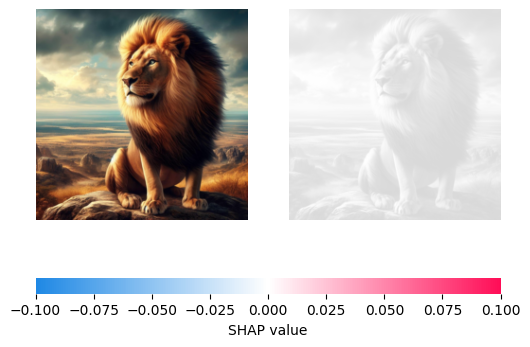

🔹 LIME Explanation for ViT-Tiny


100%|██████████| 1500/1500 [00:08<00:00, 176.02it/s]


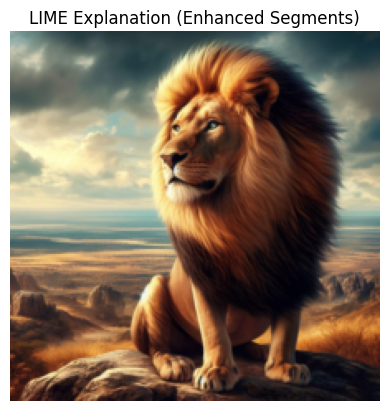


🔷 Interpreting ResNet-18...
🔹 SHAP Explanation for ResNet-18


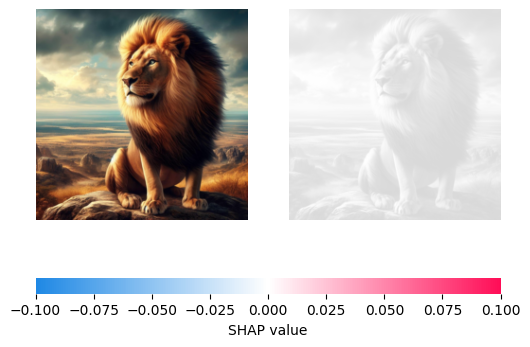

🔹 LIME Explanation for ResNet-18


100%|██████████| 1500/1500 [00:17<00:00, 85.24it/s]


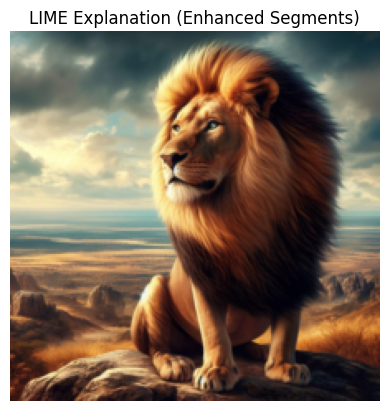

/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


🔹 Grad-CAM for ResNet-18


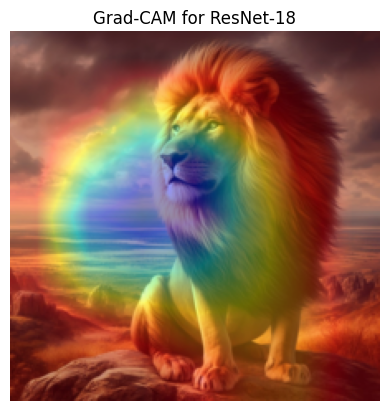


🔷 Interpreting ResNet-101...
🔹 SHAP Explanation for ResNet-101


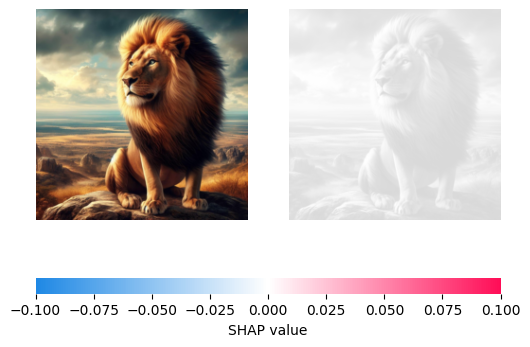

🔹 LIME Explanation for ResNet-101


100%|██████████| 1500/1500 [00:52<00:00, 28.47it/s]


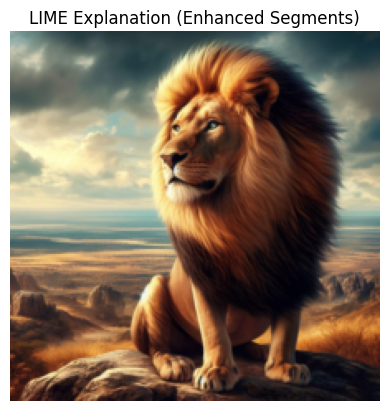

/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


🔹 Grad-CAM for ResNet-101


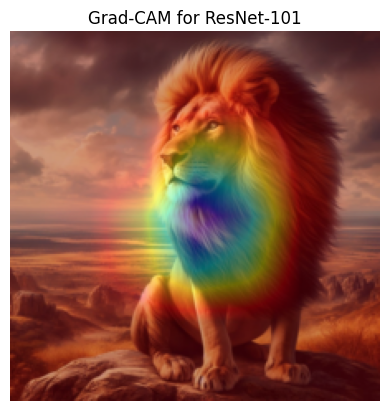

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE/8 (12).jpg'

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import shap
import lime.lime_image
import timm
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.autograd import Function
from PIL import Image

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Load Models
def load_model(model_name):
    if model_name == "ViT-Tiny":
        model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    elif model_name == "ResNet-18":
        model = models.resnet18(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)
        num_ftrs = model.fc.in_features
        model.fc = torch.nn.Linear(num_ftrs, 2)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.load_state_dict(torch.load(MODEL_PATHS[model_name], map_location=device))
    model.eval()
    return model.to(device)

# ✅ Preprocessing Function (Now Upscales 32x32 to 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Upscaling small images
    transforms.ToTensor(),
])

# ✅ Load Test Image
def load_test_image(image_path):
    image = Image.open(image_path).convert("RGB")

    # ✅ Upscale if too small
    if image.size[0] < 224 or image.size[1] < 224:
        print(f"🔹 Upscaling {image.size} to 224x224")
        image = image.resize((224, 224), Image.BICUBIC)

    image = transform(image).unsqueeze(0).to(device)
    return image

# ✅ SHAP Explanation
def explain_with_shap(model, image):
    explainer = shap.GradientExplainer(model, image)
    shap_values = explainer.shap_values(image)

    if isinstance(shap_values, list):
        shap_values_fixed = [np.sum(shap_values[i], axis=(0, -1)).transpose(1, 2, 0) for i in range(len(shap_values))]
    else:
        shap_values_fixed = np.sum(shap_values, axis=(0, -1)).transpose(1, 2, 0)

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    shap.image_plot([shap_values_fixed], image_np)

# ✅ LIME Explanation (Modified with Smaller Segments)
def explain_with_lime(model, image):
    explainer_lime = lime.lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
        preds = model(images)
        return F.softmax(preds, dim=1).cpu().detach().numpy()

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    lime_explanation = explainer_lime.explain_instance(
        image_np, predict_fn, top_labels=2, hide_color=0, num_samples=1500
    )

    # ✅ Increase granularity (more segments)
    temp, mask = lime_explanation.get_image_and_mask(
        lime_explanation.top_labels[0], positive_only=True, num_features=15, hide_rest=False
    )

    plt.imshow(temp)
    plt.title("LIME Explanation (Enhanced Segments)")
    plt.axis("off")
    plt.show()

# ✅ Grad-CAM Implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_heatmap(self, image, class_idx):
        self.model.zero_grad()
        output = self.model(image)
        target = output[:, class_idx]
        target.backward()

        gradients = self.gradients.cpu().detach().numpy()
        activations = self.activations.cpu().detach().numpy()
        pooled_gradients = np.mean(gradients, axis=(2, 3), keepdims=True)

        heatmap = np.mean(pooled_gradients * activations, axis=1).squeeze()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)

        return heatmap

# ✅ Generate Grad-CAM Visualization (Fixed Blending Issue)
def explain_with_gradcam(model, image, model_name):
    if "ResNet" in model_name:
        target_layer = model.layer4[-1]
    else:
        print("Grad-CAM is not applicable to transformer-based models like ViT.")
        return

    gradcam = GradCAM(model, target_layer)
    class_idx = model(image).argmax().item()
    heatmap = gradcam.generate_heatmap(image, class_idx)

    image_np = image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # ✅ Convert image_np to uint8
    image_np = (image_np * 255).astype(np.uint8)

    # ✅ Fix blending issue
    superimposed_image = cv2.addWeighted(image_np.astype(np.float32), 0.6, heatmap.astype(np.float32), 0.4, 0)

    plt.imshow(superimposed_image.astype(np.uint8))
    plt.title(f"Grad-CAM for {model_name}")
    plt.axis("off")
    plt.show()

# ✅ Paths to Saved Models
MODEL_PATHS = {
    "ViT-Tiny": "ViT-Tiny_best_best.pth",
    "ResNet-18": "best_resnet18_model.pth",
    "ResNet-101": "resnet101_best_ajay.pth"
}

# ✅ Run for Each Model
image_paths = [
    "/Users/amritaajaysagar/Downloads/ai-generated-8321374_1280.jpg",
    "/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE/8 (12).jpg",
    "/Users/amritaajaysagar/Downloads/archive/test_subset/REAL/15 (5).jpg",
]

for image_path in image_paths:
    test_image = load_test_image(image_path)
    print(f"🔷 Processing: {image_path}")

    for model_name in MODEL_PATHS.keys():
        print(f"\n🔷 Interpreting {model_name}...")
        model = load_model(model_name)

        # SHAP Explanation
        print(f"🔹 SHAP Explanation for {model_name}")
        explain_with_shap(model, test_image)

        # LIME Explanation
        print(f"🔹 LIME Explanation for {model_name}")
        explain_with_lime(model, test_image)

        # Grad-CAM (Only for CNNs)
        if "ResNet" in model_name:
            print(f"🔹 Grad-CAM for {model_name}")
            explain_with_gradcam(model, test_image, model_name)


###  Model Evaluation

The ViT-Tiny model was evaluated, and its training loss was plotted across epochs. The loss curve shows a steep decline initially, followed by a smooth decreasing curve, indicating stable learning and good convergence by the 5th epoch.


/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Class Mapping: {'FAKE': 0, 'REAL': 1}

Training ViT-Tiny...


/var/folders/qt/ph7q1jgd63g6qwtrx8jym_740000gn/T/ipykernel_39648/1010036923.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/qt/ph7q1jgd63g6qwtrx8jym_740000gn/T/ipykernel_39648/1010036923.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


✅ Epoch 1/8 - ViT-Tiny Loss: 0.6341 | Accuracy: 64.70%
📊 Validation Accuracy: 84.50%
🎯 Model Saved!
✅ Epoch 2/8 - ViT-Tiny Loss: 0.3651 | Accuracy: 82.10%
📊 Validation Accuracy: 86.50%
🎯 Model Saved!
✅ Epoch 3/8 - ViT-Tiny Loss: 0.2496 | Accuracy: 88.90%
📊 Validation Accuracy: 91.50%
🎯 Model Saved!
✅ Epoch 4/8 - ViT-Tiny Loss: 0.1928 | Accuracy: 92.70%
📊 Validation Accuracy: 90.00%
✅ Epoch 5/8 - ViT-Tiny Loss: 0.1466 | Accuracy: 94.10%
📊 Validation Accuracy: 90.50%
🚀 No improvement for 2 epochs. Stopping training!
📊 Logs saved at ViT-Tiny_training_logs.npy

✅ Model Training Completed! Model saved as 'ViT-Tiny_best_mar23.pth'


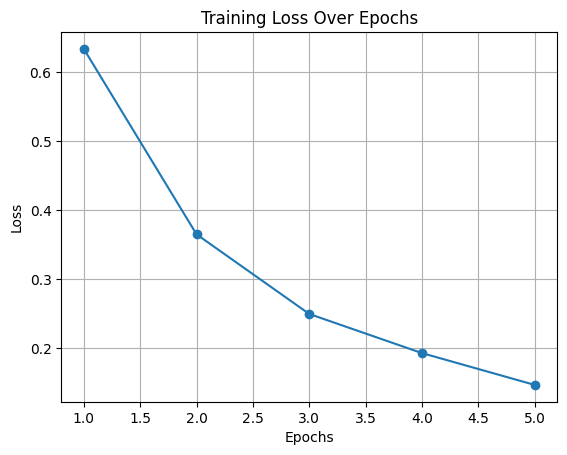

In [ ]:
import os
import time
import torch
import random
import timm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from PIL import Image

#  Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  Paths
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset"
MODEL_SAVE_PATH = "ViT-Tiny_best_Mar23.pth"
LOG_PATH = "ViT-Tiny_training_logs.npy"

#  Hyperparameters
BATCH_SIZE = 64  # Reduce batch size to avoid memory issues
EPOCHS = 8       # Faster training
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 2
TRAIN_SAMPLES_PER_CLASS = 500
TEST_SAMPLES_PER_CLASS = 100

#  Image Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

#  Load Datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transforms)
test_dataset = ImageFolder(root=TEST_PATH, transform=test_transforms)

#  Select Subset for Faster Training
def select_subset(dataset, num_samples_per_class):
    indices = []
    for class_idx in dataset.class_to_idx.values():
        class_samples = [i for i in range(len(dataset)) if dataset.targets[i] == class_idx]
        indices.extend(random.sample(class_samples, min(num_samples_per_class, len(class_samples))))
    return Subset(dataset, indices)

train_dataset = select_subset(train_dataset, TRAIN_SAMPLES_PER_CLASS)
test_dataset = select_subset(test_dataset, TEST_SAMPLES_PER_CLASS)

#  Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Class Mapping:", train_dataset.dataset.class_to_idx)

#  Define ViT-Tiny Model
def get_vit_tiny():
    model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=2)
    return model.to(device)

#  Training Function (Logs Loss & Accuracy)
def train_model(model, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = GradScaler()

    best_acc = 0.0
    patience_counter = 0
    loss_history = []
    accuracy_history = []
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        total, correct, epoch_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()

        train_acc = correct / total * 100
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        accuracy_history.append(train_acc)

        print(f"✅ Epoch {epoch+1}/{EPOCHS} - {model_name} Loss: {avg_loss:.4f} | Accuracy: {train_acc:.2f}%")

        # Validation Step
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total * 100
        scheduler.step()
        print(f"📊 Validation Accuracy: {val_acc:.2f}%")

        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("🎯 Model Saved!")

        else:
            patience_counter += 1

        # Early Stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"🚀 No improvement for {EARLY_STOPPING_PATIENCE} epochs. Stopping training!")
            break

    # Save Logs
    np.save(LOG_PATH, {'loss': loss_history, 'accuracy': accuracy_history})
    print(f"📊 Logs saved at {LOG_PATH}")

#  Run Training
vit_model = get_vit_tiny()
print("\nTraining ViT-Tiny...")
train_model(vit_model, "ViT-Tiny")
print("\n✅ Model Training Completed! Model saved as 'ViT-Tiny_best_mar23.pth'")

#  Plot Loss Function
def plot_loss():
    logs = np.load(LOG_PATH, allow_pickle=True).item()
    loss_values = logs['loss']
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid()
    plt.show()

plot_loss()


### Visualizing Self-Attention in ViT

We extracted self-attention maps from the final block of the ViT-Tiny model using forward hooks. The resulting heatmap shows how the model distributes its attention across image patches. The map highlights the regions most relevant to the classification, offering insight into the model's decision-making process.

Using device: cpu
🔍 Raw Attention Output Shape: torch.Size([1, 197, 192])
⚠️ Attention lacks head dimension! Averaging features instead.
🔹 Extracted attention shape: (197,)
🧐 Current num_tokens: 197
✅ Removing CLS token.
🧐 Shape after CLS token removal: (196, 1)
🧐 Normalization Range: min=-0.008045676164329052, max=-0.006368585396558046


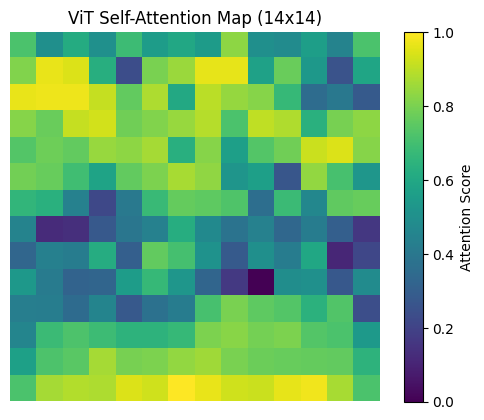

In [ ]:
import torch
import numpy as np
import timm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

#  Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ViT-Tiny Model
def load_vit_model(model_path):
    model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

#  Preprocessing (Ensure 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load and Prepare Image
def load_test_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image

# Extract Self-Attention Maps from ViT (Fixed)
def get_vit_attention(model, image):
    """Extract self-attention weights from the last ViT block."""

    attention_weights = []

    def hook_fn(module, input, output):
        """Extract self-attention weights correctly from ViT."""
        print(f"🔍 Raw Attention Output Shape: {output.shape}")  # Debugging
        if isinstance(output, tuple):
            attn_probs = output[0]  # Extract the correct attention map
        else:
            attn_probs = output

        if len(attn_probs.shape) == 3:  # (batch, tokens, features)
            print("⚠️ Attention lacks head dimension! Averaging features instead.")
            attn_probs = attn_probs.mean(dim=-1, keepdim=True)  # Convert to shape (batch, tokens, 1)

        attention_weights.append(attn_probs.detach().cpu().numpy())  # Store attention maps

    # Hook into the last transformer's **attention layer**
    last_block = model.blocks[-1].attn
    hook_handle = last_block.register_forward_hook(hook_fn)

    # Run a forward pass to capture attention
    with torch.no_grad():
        _ = model.forward_features(image)  # This triggers the hook

    # Remove hook after getting the output
    hook_handle.remove()

    if not attention_weights:
        raise RuntimeError("❌ Failed to extract attention weights! Check the model structure.")

    # Process attention correctly
    attn_map = attention_weights[0]  # Expected Shape: (batch, tokens, 1) or (tokens,)
    attn_map = np.array(attn_map).squeeze()  # Remove singleton dimensions
    print(f"🔹 Extracted attention shape: {attn_map.shape}")  # Debugging step

    # Ensure correct number of tokens (CLS + patches)
    num_tokens = attn_map.shape[0]
    print(f"🧐 Current num_tokens: {num_tokens}")  # Debugging

    if len(attn_map.shape) == 1:  # If it's 1D, reshape it for safe slicing
        attn_map = attn_map.reshape(-1, 1)  # Convert to (197, 1)

    if num_tokens == 197:  # 196 patches + CLS token
        print("✅ Removing CLS token.")
        attn_map = attn_map[1:, :]  # Remove CLS token
    elif num_tokens != 196:
        print(f"⚠️ Unexpected number of tokens: {num_tokens}, expected 196.")
        return attn_map  # Keep original if unexpected

    print(f"🧐 Shape after CLS token removal: {attn_map.shape}")  # Debugging

    #  Prevent empty array errors
    if attn_map.size == 0:
        raise ValueError("⚠️ Empty attention map after processing! Aborting.")

    #  Ensure correct reshaping
    num_patches = attn_map.shape[0]  # Should be 196 (14x14)
    grid_size = int(np.sqrt(num_patches))

    if grid_size * grid_size == num_patches:
        attn_map = attn_map.reshape(grid_size, grid_size)
    else:
        print(f"⚠️ Unexpected number of patches: {num_patches}. Using original shape.")

    #  Normalize attention for visualization
    attn_min, attn_max = attn_map.min(), attn_map.max()
    print(f"🧐 Normalization Range: min={attn_min}, max={attn_max}")  # Debugging

    if attn_max - attn_min == 0:
        print("⚠️ Skipping normalization due to zero range.")
    else:
        attn_map = (attn_map - attn_min) / (attn_max - attn_min)

    return attn_map.squeeze()

# Visualize Self-Attention
def visualize_vit_attention(attn_map):
    """Display self-attention heatmap with correct normalization and dynamic reshaping."""


    plt.imshow(attn_map, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Attention Score")
    plt.title(f"ViT Self-Attention Map ({attn_map.shape[0]}x{attn_map.shape[1]})")
    plt.axis("off")
    plt.show()

#  Paths
MODEL_PATH = "ViT-Tiny_best_Mar23.pth"  # Updated model path
IMAGE_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE/7 (10).jpg"

#  Run Visualization
vit_model = load_vit_model(MODEL_PATH)
test_image = load_test_image(IMAGE_PATH)
attn_map = get_vit_attention(vit_model, test_image)

visualize_vit_attention(attn_map)



✅ Model (resnet101) Loaded Successfully from resnet101_best_ajay.pth!



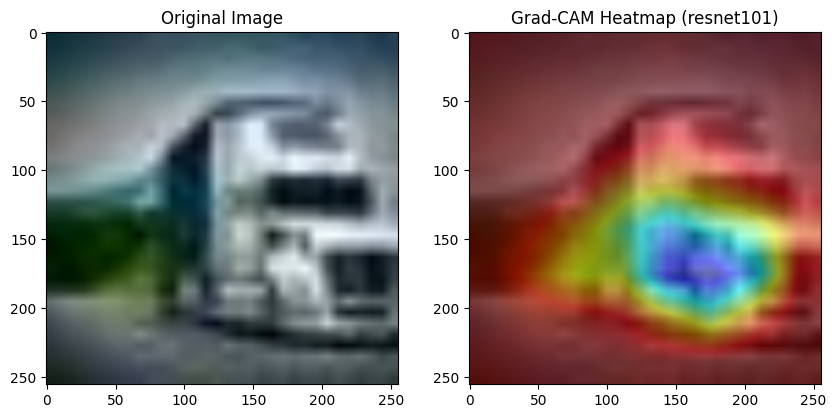

In [ ]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.models.feature_extraction import create_feature_extractor
from PIL import Image

def generate_gradcam(model_path, image_path, model_arch="resnet101", target_layer="layer4"):
    """
    Generates Grad-CAM heatmap for a given model and image.

    Parameters:
    - model_path (str): Path to the saved PyTorch model (.pth file).
    - image_path (str): Path to the image file.
    - model_arch (str): Model architecture (default is 'resnet101').
    - target_layer (str): Layer from which Grad-CAM is extracted (default is 'layer4' for ResNet).

    Output:
    - Displays the original image and Grad-CAM heatmap.
    """

    # Set Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Pretrained Model
    model = getattr(models, model_arch)(weights=None)  # Load model structure dynamically
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 2)  # Modify for binary classification
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load saved weights
    model = model.to(device)
    model.eval()

    print(f"\n✅ Model ({model_arch}) Loaded Successfully from {model_path}!\n")

    # Define Image Preprocessing Transform
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for ResNet
    ])

    # Load and preprocess image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB
    img_pil = Image.fromarray(img)  # Convert NumPy array to PIL image
    tensor_img = transform(img_pil).unsqueeze(0).to(device)  # Transform image to tensor

    # Extract features from the target layer
    feature_extractor = create_feature_extractor(model, return_nodes={target_layer: "features"})

    with torch.no_grad():
        features = feature_extractor(tensor_img)["features"]

    # Compute Grad-CAM
    grad_cam = features.squeeze().mean(dim=0).cpu().numpy()
    grad_cam = np.maximum(grad_cam, 0)  # Apply ReLU
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())  # Normalize
    grad_cam = cv2.resize(grad_cam, (256, 256))

    # Apply Heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)

    # Display Results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Grad-CAM Heatmap ({model_arch})")

    plt.show()

# **Example Usage**
#model_path = "resnet101_fake_vs_real.pth"
model_path = "resnet101_best_ajay.pth"
#model_path = "best_resnet18_model.pth"


image_path = "/Users/amritaajaysagar/Downloads/archive/test/FAKE/0 (10).jpg"
generate_gradcam(model_path, image_path, model_arch="resnet101", target_layer="layer4")
#generate_gradcam(model_path, image_path, model_arch="resnet18", target_layer="layer4")

/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Class Mapping: {'FAKE': 0, 'REAL': 1}

Training ViT-Tiny...


/var/folders/qt/ph7q1jgd63g6qwtrx8jym_740000gn/T/ipykernel_39648/1010036923.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/qt/ph7q1jgd63g6qwtrx8jym_740000gn/T/ipykernel_39648/1010036923.py:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/amritaajaysagar/miniconda3/envs/image_env/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


✅ Epoch 1/8 - ViT-Tiny Loss: 0.6341 | Accuracy: 64.70%
📊 Validation Accuracy: 84.50%
🎯 Model Saved!
✅ Epoch 2/8 - ViT-Tiny Loss: 0.3651 | Accuracy: 82.10%
📊 Validation Accuracy: 86.50%
🎯 Model Saved!
✅ Epoch 3/8 - ViT-Tiny Loss: 0.2496 | Accuracy: 88.90%
📊 Validation Accuracy: 91.50%
🎯 Model Saved!
✅ Epoch 4/8 - ViT-Tiny Loss: 0.1928 | Accuracy: 92.70%
📊 Validation Accuracy: 90.00%
✅ Epoch 5/8 - ViT-Tiny Loss: 0.1466 | Accuracy: 94.10%
📊 Validation Accuracy: 90.50%
🚀 No improvement for 2 epochs. Stopping training!
📊 Logs saved at ViT-Tiny_training_logs.npy

✅ Model Training Completed! Model saved as 'ViT-Tiny_best_mar23.pth'


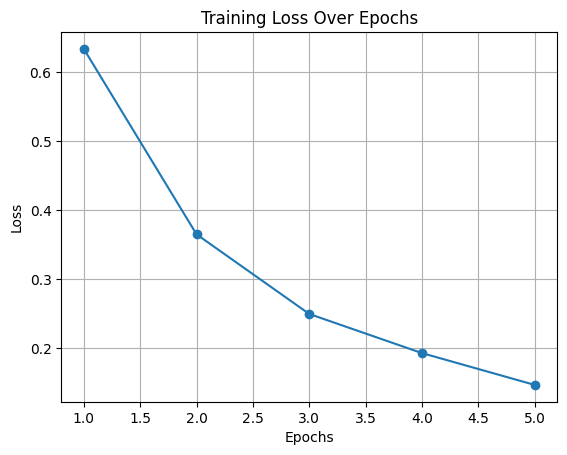

In [ ]:
#Self attention for VIT model
import os
import time
import torch
import random
import timm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler
from PIL import Image

# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ✅ Paths
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset"
MODEL_SAVE_PATH = "ViT-Tiny_best_Mar23.pth"
LOG_PATH = "ViT-Tiny_training_logs.npy"

# ✅ Hyperparameters
BATCH_SIZE = 64  # Reduce batch size to avoid memory issues
EPOCHS = 8       # Faster training
LEARNING_RATE = 1e-4
EARLY_STOPPING_PATIENCE = 2
TRAIN_SAMPLES_PER_CLASS = 500
TEST_SAMPLES_PER_CLASS = 100

# ✅ Image Transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Load Datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform=train_transforms)
test_dataset = ImageFolder(root=TEST_PATH, transform=test_transforms)

# ✅ Select Subset for Faster Training
def select_subset(dataset, num_samples_per_class):
    indices = []
    for class_idx in dataset.class_to_idx.values():
        class_samples = [i for i in range(len(dataset)) if dataset.targets[i] == class_idx]
        indices.extend(random.sample(class_samples, min(num_samples_per_class, len(class_samples))))
    return Subset(dataset, indices)

train_dataset = select_subset(train_dataset, TRAIN_SAMPLES_PER_CLASS)
test_dataset = select_subset(test_dataset, TEST_SAMPLES_PER_CLASS)

# ✅ Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Class Mapping:", train_dataset.dataset.class_to_idx)

# ✅ Define ViT-Tiny Model
def get_vit_tiny():
    model = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=2)
    return model.to(device)

# ✅ Training Function (Logs Loss & Accuracy)
def train_model(model, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = GradScaler()

    best_acc = 0.0
    patience_counter = 0
    loss_history = []
    accuracy_history = []
    start_time = time.time()

    for epoch in range(EPOCHS):
        model.train()
        total, correct, epoch_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()

        train_acc = correct / total * 100
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        accuracy_history.append(train_acc)

        print(f"✅ Epoch {epoch+1}/{EPOCHS} - {model_name} Loss: {avg_loss:.4f} | Accuracy: {train_acc:.2f}%")

        # Validation Step
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for val_images, val_labels in test_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                _, val_preds = torch.max(val_outputs, 1)
                val_correct += (val_preds == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_acc = val_correct / val_total * 100
        scheduler.step()
        print(f"📊 Validation Accuracy: {val_acc:.2f}%")

        # Save Best Model
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print("🎯 Model Saved!")

        else:
            patience_counter += 1

        # Early Stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"🚀 No improvement for {EARLY_STOPPING_PATIENCE} epochs. Stopping training!")
            break

    # Save Logs
    np.save(LOG_PATH, {'loss': loss_history, 'accuracy': accuracy_history})
    print(f"📊 Logs saved at {LOG_PATH}")

# ✅ Run Training
vit_model = get_vit_tiny()
print("\nTraining ViT-Tiny...")
train_model(vit_model, "ViT-Tiny")
print("\n✅ Model Training Completed! Model saved as 'ViT-Tiny_best_mar23.pth'")

# ✅ Plot Loss Function
def plot_loss():
    logs = np.load(LOG_PATH, allow_pickle=True).item()
    loss_values = logs['loss']
    plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.grid()
    plt.show()

plot_loss()


In [ ]:
#Self attention code
import torch
import numpy as np
import timm
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

#  Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#  Load ViT-Tiny Model
def load_vit_model(model_path):
    model = timm.create_model("vit_tiny_patch16_224", pretrained=False, num_classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

#  Preprocessing (Ensure 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#  Load and Prepare Image
def load_test_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image

#  Extract Self-Attention Maps from ViT (Fixed)
def get_vit_attention(model, image):
    """Extract self-attention weights from the last ViT block."""

    attention_weights = []

    def hook_fn(module, input, output):
        """Extract self-attention weights correctly from ViT."""
        print(f"🔍 Raw Attention Output Shape: {output.shape}")  # Debugging
        if isinstance(output, tuple):
            attn_probs = output[0]  # Extract the correct attention map
        else:
            attn_probs = output

        if len(attn_probs.shape) == 3:  # (batch, tokens, features)
            print("⚠️ Attention lacks head dimension! Averaging features instead.")
            attn_probs = attn_probs.mean(dim=-1, keepdim=True)  # Convert to shape (batch, tokens, 1)

        attention_weights.append(attn_probs.detach().cpu().numpy())  # Store attention maps

    #  Hook into the last transformer's **attention layer**
    last_block = model.blocks[-1].attn
    hook_handle = last_block.register_forward_hook(hook_fn)

    # Run a forward pass to capture attention
    with torch.no_grad():
        _ = model.forward_features(image)  # This triggers the hook

    #  Remove hook after getting the output
    hook_handle.remove()

    if not attention_weights:
        raise RuntimeError("❌ Failed to extract attention weights! Check the model structure.")

    #  Process attention correctly
    attn_map = attention_weights[0]  # Expected Shape: (batch, tokens, 1) or (tokens,)
    attn_map = np.array(attn_map).squeeze()  # Remove singleton dimensions
    print(f"🔹 Extracted attention shape: {attn_map.shape}")  # Debugging step

    #  Ensure correct number of tokens (CLS + patches)
    num_tokens = attn_map.shape[0]
    print(f"🧐 Current num_tokens: {num_tokens}")  # Debugging

    if len(attn_map.shape) == 1:  # If it's 1D, reshape it for safe slicing
        attn_map = attn_map.reshape(-1, 1)  # Convert to (197, 1)

    if num_tokens == 197:  # 196 patches + CLS token
        print("✅ Removing CLS token.")
        attn_map = attn_map[1:, :]  # Remove CLS token
    elif num_tokens != 196:
        print(f"⚠️ Unexpected number of tokens: {num_tokens}, expected 196.")
        return attn_map  # Keep original if unexpected

    print(f"🧐 Shape after CLS token removal: {attn_map.shape}")  # Debugging

    #  Prevent empty array errors
    if attn_map.size == 0:
        raise ValueError("⚠️ Empty attention map after processing! Aborting.")

    #  Ensure correct reshaping
    num_patches = attn_map.shape[0]  # Should be 196 (14x14)
    grid_size = int(np.sqrt(num_patches))

    if grid_size * grid_size == num_patches:
        attn_map = attn_map.reshape(grid_size, grid_size)
    else:
        print(f"⚠️ Unexpected number of patches: {num_patches}. Using original shape.")

    #  Normalize attention for visualization
    attn_min, attn_max = attn_map.min(), attn_map.max()
    print(f"🧐 Normalization Range: min={attn_min}, max={attn_max}")  # Debugging

    if attn_max - attn_min == 0:
        print("⚠️ Skipping normalization due to zero range.")
    else:
        attn_map = (attn_map - attn_min) / (attn_max - attn_min)

    return attn_map.squeeze()

#  Visualize Self-Attention
def visualize_vit_attention(attn_map):
    """Display self-attention heatmap with correct normalization and dynamic reshaping."""


    plt.imshow(attn_map, cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Attention Score")
    plt.title(f"ViT Self-Attention Map ({attn_map.shape[0]}x{attn_map.shape[1]})")
    plt.axis("off")
    plt.show()

#  Paths
MODEL_PATH = "ViT-Tiny_best_Mar23.pth"  # Updated model path
IMAGE_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset/FAKE/7 (10).jpg"

#  Run Visualization
vit_model = load_vit_model(MODEL_PATH)
test_image = load_test_image(IMAGE_PATH)
attn_map = get_vit_attention(vit_model, test_image)

visualize_vit_attention(attn_map)


🔍 Raw Attention Output Shape: torch.Size([1, 197, 192])
⚠️ Attention lacks head dimension! Averaging features instead.
🔹 Extracted attention shape: (197,)
🧐 Current num_tokens: 197
✅ Removing CLS token.
🧐 Shape after CLS token removal: (196, 1)
🧐 Normalization Range: min=-0.008326037786900997, max=-0.006621356587857008


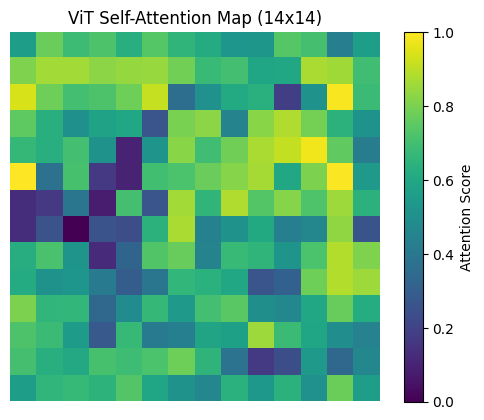

In [ ]:
#  Paths
MODEL_PATH = "ViT-Tiny_best_Mar23.pth"  # Updated model path
IMAGE_PATH = "/Users/amritaajaysagar/Downloads/archive/test/FAKE/0 (10).jpg"

#  Run Visualization
vit_model = load_vit_model(MODEL_PATH)
test_image = load_test_image(IMAGE_PATH)
attn_map = get_vit_attention(vit_model, test_image)

visualize_vit_attention(attn_map)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import numpy as np
import os
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
TRAIN_PATH = "/Users/amritaajaysagar/Downloads/archive_preprocessed/train_subset"
TEST_PATH = "/Users/amritaajaysagar/Downloads/archive/test_subset"
SAVE_DIR = "./"  # Update if needed

# Hyperparameters
EPOCHS = 8
BATCH_SIZE = 32
LR = 1e-4
PATIENCE = 2
SAMPLES_PER_CLASS = 500

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Subset selection
def select_subset(dataset, n):
    indices = []
    for class_idx in dataset.class_to_idx.values():
        class_samples = [i for i in range(len(dataset)) if dataset.targets[i] == class_idx]
        indices.extend(random.sample(class_samples, min(n, len(class_samples))))
    return Subset(dataset, indices)

# Load datasets
train_dataset = select_subset(ImageFolder(TRAIN_PATH, transform), SAMPLES_PER_CLASS)
test_dataset = select_subset(ImageFolder(TEST_PATH, transform), SAMPLES_PER_CLASS // 5)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Training function
def train_and_log(model_name, model_path):
    if model_name == "ResNet-18":
        model = models.resnet18(weights=None)
    elif model_name == "ResNet-101":
        model = models.resnet101(weights=None)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    loss_history = []
    accuracy_history = []
    best_acc = 0.0
    patience_counter = 0

    for epoch in range(EPOCHS):
        model.train()
        total, correct, running_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total * 100
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_acc)
        print(f"{model_name} - Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

        scheduler.step()

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("⏹️ Early stopping.")
                break

    log_path = os.path.join(SAVE_DIR, f"{model_name}_training_logs.npy")
    np.save(log_path, {'loss': loss_history, 'accuracy': accuracy_history})
    print(f"✅ Logs saved at: {log_path}")

# Run for both models
train_and_log("ResNet-18", "/Users/amritaajaysagar/Library/Mobile Documents/com~apple~CloudDocs/Desktop/flask_app/models/best_resnet18_model.pth")
train_and_log("ResNet-101", "/Users/amritaajaysagar/Library/Mobile Documents/com~apple~CloudDocs/Desktop/flask_app/models/resnet101_best_ajay.pth")


ResNet-18 - Epoch 1 | Loss: 0.4367 | Acc: 83.40%
ResNet-18 - Epoch 2 | Loss: 0.1487 | Acc: 94.50%
ResNet-18 - Epoch 3 | Loss: 0.0943 | Acc: 97.00%
ResNet-18 - Epoch 4 | Loss: 0.0594 | Acc: 98.00%
ResNet-18 - Epoch 5 | Loss: 0.0413 | Acc: 99.10%
ResNet-18 - Epoch 6 | Loss: 0.0438 | Acc: 98.70%
ResNet-18 - Epoch 7 | Loss: 0.0238 | Acc: 99.60%
ResNet-18 - Epoch 8 | Loss: 0.0246 | Acc: 99.40%
✅ Logs saved at: ./ResNet-18_training_logs.npy
ResNet-101 - Epoch 1 | Loss: 0.4143 | Acc: 80.60%
ResNet-101 - Epoch 2 | Loss: 0.1947 | Acc: 93.00%
ResNet-101 - Epoch 3 | Loss: 0.0957 | Acc: 97.30%
ResNet-101 - Epoch 4 | Loss: 0.0791 | Acc: 98.10%
ResNet-101 - Epoch 5 | Loss: 0.0441 | Acc: 98.70%
ResNet-101 - Epoch 6 | Loss: 0.0486 | Acc: 98.10%
ResNet-101 - Epoch 7 | Loss: 0.0404 | Acc: 99.40%
ResNet-101 - Epoch 8 | Loss: 0.0135 | Acc: 99.90%
✅ Logs saved at: ./ResNet-101_training_logs.npy


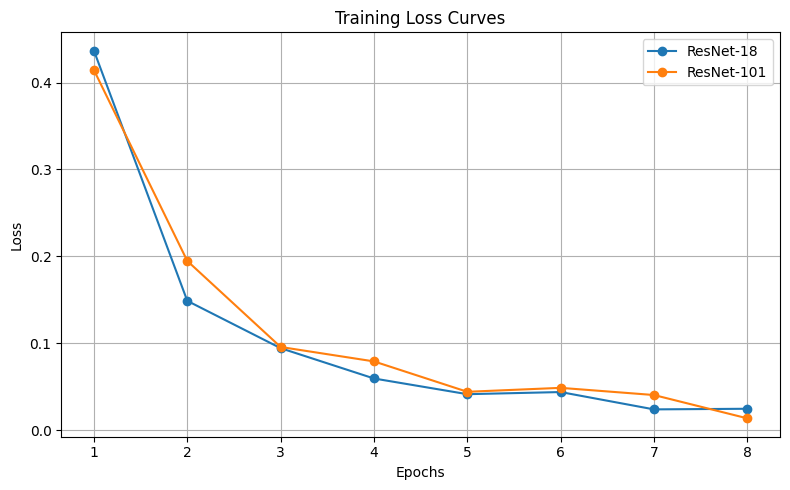

In [6]:
import matplotlib.pyplot as plt

# Load and plot logs
def plot_loss_curve(models):
    plt.figure(figsize=(8, 5))
    for model_name, log_file in models.items():
        logs = np.load(log_file, allow_pickle=True).item()
        loss = logs['loss']
        plt.plot(range(1, len(loss)+1), loss, marker='o', label=model_name)

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curve({
    "ResNet-18": "./ResNet-18_training_logs.npy",
    "ResNet-101": "./ResNet-101_training_logs.npy"
})


## Conclusion

Among the models tested, **ResNet-101** consistently delivered high accuracy and clearer visual interpretability using Grad-CAM. **ViT-Tiny** showed competitive accuracy but offered less spatially intuitive explanations due to its patch-based architecture. While **SHAP and LIME** offered limited visual insights for ViT on low-resolution images, **Grad-CAM and self-attention maps** proved more useful in understanding model focus. This project highlights the value of combining traditional CNNs and transformers with interpretability techniques to detect image authenticity.
